# 종합실습 2

# Scale불량 Data

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl

matplotlib.rc("font",family="NanumGothic")
matplotlib.rc("axes",unicode_minus=False)

import graphviz

from statsmodels.api import qqplot, add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import qqplot
import statsmodels.api as sm
import scipy.stats
from statsmodels.formula.api import logit
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.tree import export_graphviz
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import math

## 데이터 불러오기 및 확인

In [3]:
df_raw = pd.read_csv('./datasets/SCALE불량.csv',encoding='euc-kr')
display(df_raw.head())
display(df_raw.info())

,plate_no,rolling_date,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,...,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_method,rolling_temp,descaling_count,work_group
0,PLT_1001,03JAN2023:07:07:53,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,...,1144,116,1133,59,259,1133,TMCP(온도제어),934,8,1조
1,PLT_1002,03JAN2023:07:21:22,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,...,1144,122,1135,53,238,1135,TMCP(온도제어),937,8,1조
2,PLT_1003,03JAN2023:07:31:15,양품,NV-E36-TM,영국,T,33,3600,19200,적용,...,1129,116,1121,55,258,1121,TMCP(온도제어),889,8,1조
3,PLT_1004,03JAN2023:07:41:01,양품,NV-E36-TM,영국,T,33,3600,19200,적용,...,1152,125,1127,68,266,1127,TMCP(온도제어),885,8,1조
4,PLT_1005,03JAN2023:07:52:40,양품,BV-EH36-TM,프랑스,T,38,3100,13300,적용,...,1140,134,1128,48,246,1128,TMCP(온도제어),873,8,1조


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   plate_no         1000 non-null   object
 1   rolling_date     1000 non-null   object
 2   scale            1000 non-null   object
 3   spec_long        1000 non-null   object
 4   spec_country     1000 non-null   object
 5   steel_kind       1000 non-null   object
 6   pt_thick         1000 non-null   int64 
 7   pt_width         1000 non-null   int64 
 8   pt_length        1000 non-null   int64 
 9   hsb              1000 non-null   object
 10  fur_no           1000 non-null   object
 11  fur_input_row    1000 non-null   object
 12  fur_heat_temp    1000 non-null   int64 
 13  fur_heat_time    1000 non-null   int64 
 14  fur_soak_temp    1000 non-null   int64 
 15  fur_soak_time    1000 non-null   int64 
 16  fur_total_time   1000 non-null   int64 
 17  fur_ex_temp      1000 non-null   i

None

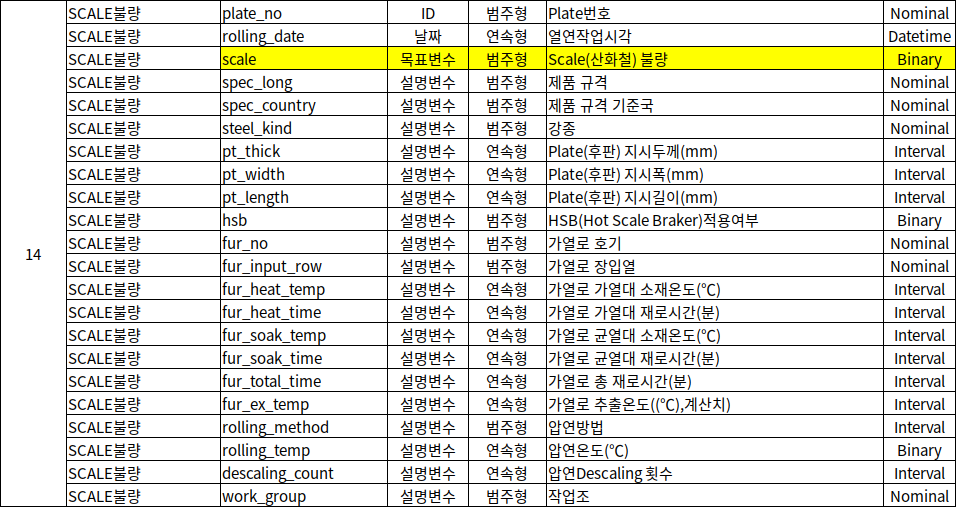

## 결측치, 중복값 확인

In [3]:
# 결측치 확인
df_raw.isnull().sum(axis = 0).sort_values(ascending=False)

plate_no           0
rolling_date       0
descaling_count    0
rolling_temp       0
rolling_method     0
fur_ex_temp        0
fur_total_time     0
fur_soak_time      0
fur_soak_temp      0
fur_heat_time      0
fur_heat_temp      0
fur_input_row      0
fur_no             0
hsb                0
pt_length          0
pt_width           0
pt_thick           0
steel_kind         0
spec_country       0
spec_long          0
scale              0
work_group         0
dtype: int64

In [4]:
# 중복값 확인
df_raw.duplicated().sum()

0

### 데이터 크기 및 결측, 중복값 확인결과
- 1000 개의 데이터 인덱스와 22개의 목표변수와 설명변수 칼럼으로 구성되어 있음
- 결측값 확인 결과 이상없음
- 중복값 확인 결과 이상없음
- 목표변수는 산화철 불량(scale)으로 범주형 변수이다.

## 데이터 정제

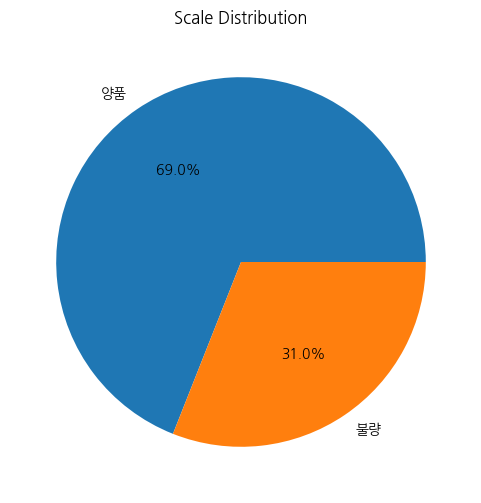

In [5]:
# 목표변수 scale 의 불량/양품 빈도 확인
value_counts = df_raw['scale'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%')
plt.title('Scale Distribution')
plt.show()

- 목표변수 scale 에 대한 결측치는 없음

In [6]:
display(df_raw.head())
display(df_raw.info())

,plate_no,rolling_date,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,...,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_method,rolling_temp,descaling_count,work_group
0,PLT_1001,03JAN2023:07:07:53,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,...,1144,116,1133,59,259,1133,TMCP(온도제어),934,8,1조
1,PLT_1002,03JAN2023:07:21:22,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,...,1144,122,1135,53,238,1135,TMCP(온도제어),937,8,1조
2,PLT_1003,03JAN2023:07:31:15,양품,NV-E36-TM,영국,T,33,3600,19200,적용,...,1129,116,1121,55,258,1121,TMCP(온도제어),889,8,1조
3,PLT_1004,03JAN2023:07:41:01,양품,NV-E36-TM,영국,T,33,3600,19200,적용,...,1152,125,1127,68,266,1127,TMCP(온도제어),885,8,1조
4,PLT_1005,03JAN2023:07:52:40,양품,BV-EH36-TM,프랑스,T,38,3100,13300,적용,...,1140,134,1128,48,246,1128,TMCP(온도제어),873,8,1조


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   plate_no         1000 non-null   object
 1   rolling_date     1000 non-null   object
 2   scale            1000 non-null   object
 3   spec_long        1000 non-null   object
 4   spec_country     1000 non-null   object
 5   steel_kind       1000 non-null   object
 6   pt_thick         1000 non-null   int64 
 7   pt_width         1000 non-null   int64 
 8   pt_length        1000 non-null   int64 
 9   hsb              1000 non-null   object
 10  fur_no           1000 non-null   object
 11  fur_input_row    1000 non-null   object
 12  fur_heat_temp    1000 non-null   int64 
 13  fur_heat_time    1000 non-null   int64 
 14  fur_soak_temp    1000 non-null   int64 
 15  fur_soak_time    1000 non-null   int64 
 16  fur_total_time   1000 non-null   int64 
 17  fur_ex_temp      1000 non-null   i

None

In [7]:
# plate_no, rolling_date 삭제
df_raw.drop(columns = ["plate_no","rolling_date"], inplace = True)

In [8]:
# 해당 데이터셋에서 descaling_count 는 연속형이 아닌 범주형이다.
df_raw['descaling_count'] = df_raw['descaling_count'].astype('object')

In [9]:
target_col = ['scale']
cat_cols = ['spec_long','spec_country','steel_kind','hsb','fur_no','fur_input_row','rolling_method','work_group','descaling_count']
con_cols = ['pt_thick','pt_width','pt_length','fur_heat_temp','fur_heat_time','fur_soak_temp','fur_soak_time','fur_total_time','fur_ex_temp','rolling_temp']

In [10]:
display(df_raw[target_col].head())
print("연속형 변수")
print(df_raw[con_cols].info())
print("범주형 변수")
print(df_raw[cat_cols].info())

,scale
0,양품
1,양품
2,양품
3,양품
4,양품


연속형 변수
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   pt_thick        1000 non-null   int64
 1   pt_width        1000 non-null   int64
 2   pt_length       1000 non-null   int64
 3   fur_heat_temp   1000 non-null   int64
 4   fur_heat_time   1000 non-null   int64
 5   fur_soak_temp   1000 non-null   int64
 6   fur_soak_time   1000 non-null   int64
 7   fur_total_time  1000 non-null   int64
 8   fur_ex_temp     1000 non-null   int64
 9   rolling_temp    1000 non-null   int64
dtypes: int64(10)
memory usage: 78.2 KB
None
범주형 변수
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   spec_long        1000 non-null   object
 1   spec_country     1000 non-null   object
 2   steel_kind       1000 non-nul

In [11]:
display(print("연속형 변수 : \n",df_raw[con_cols].head()))
display(print("범주형 변수 : \n",df_raw[cat_cols].head()))

연속형 변수 : 
    pt_thick  pt_width  pt_length  fur_heat_temp  fur_heat_time  fur_soak_temp  \
0        32      3700      15100           1144            116           1133   
1        32      3700      15100           1144            122           1135   
2        33      3600      19200           1129            116           1121   
3        33      3600      19200           1152            125           1127   
4        38      3100      13300           1140            134           1128   

   fur_soak_time  fur_total_time  fur_ex_temp  rolling_temp  
0             59             259         1133           934  
1             53             238         1135           937  
2             55             258         1121           889  
3             68             266         1127           885  
4             48             246         1128           873  


None

범주형 변수 : 
     spec_long spec_country steel_kind hsb fur_no fur_input_row rolling_method  \
0  AB/EH32-TM           미국          T  적용    1호기            1열     TMCP(온도제어)   
1  AB/EH32-TM           미국          T  적용    1호기            2열     TMCP(온도제어)   
2   NV-E36-TM           영국          T  적용    2호기            1열     TMCP(온도제어)   
3   NV-E36-TM           영국          T  적용    2호기            2열     TMCP(온도제어)   
4  BV-EH36-TM          프랑스          T  적용    3호기            1열     TMCP(온도제어)   

  work_group descaling_count  
0         1조               8  
1         1조               8  
2         1조               8  
3         1조               8  
4         1조               8  


None

## 명목형 변수 데이터 확인

In [12]:
df_raw["steel_kind"].unique()

array(['T', 'C'], dtype=object)

- 강종(steel_kind)은 T 종류, C 종류로 2가지의 값만 가지므로 명목형 변수이다. (C : Carbon steel, T : Tool steel)

In [13]:
df_raw["fur_input_row"].unique()

array(['1열', '2열'], dtype=object)

- 가열로 장입열(fur_input_row)는 1열과 2열으로 2가지의 값만 가지므로 명목형 변수이다.

In [14]:
df_raw["descaling_count"].unique()

array([8, 7, 5, 6, 10, 9], dtype=object)

- 압연 횟수(descaling_count) 는 데이터셋에서는 연속형 변수라고 되어있었다.
- 그러나 가지는 값의 가짓수가 적은 명목형 변수이다.

In [15]:
df_raw["spec_long"].unique()

array(['AB/EH32-TM', 'NV-E36-TM', 'BV-EH36-TM', 'AB/EH36-TM', 'COMMON',
       'BV-AH32-TM', 'GL-E32-TM', 'GL-E36-TM', 'BV-EH32-TM', 'KS-HSB600',
       'LR-EH36-TM', 'BV-B', 'AB/B', 'LR-B', 'JS-SM490YB', 'KR-B', 'LR-A',
       'JS-SM490A', 'KS-SM400B', 'JS-SM400B', 'KS-SS400', 'KR-A',
       'JS-SS400', 'NV-A', 'KS-SM400A', 'KS-SM490B', 'V42JBN3', 'AB/A',
       'A516-60', 'BV-AH32', 'JS-SM490YA', 'AB/AH32', 'GL-A32', 'LR-AH32',
       'CCS-B', 'NV-B', 'NV-A32', 'KS-SM490A', 'GL-A', 'NK-KA32',
       'LR-AH36', 'A709-36', 'KR-AH32', 'BV-A', 'NK-KA', 'NV-D36-TM',
       'NK-KA32-TM', 'GL-A32-TM', 'LR-AH36-TM', 'LR-EH32-TM', 'NV-E32-TM',
       'KS-HSB500', 'API-2W-50T', 'GL-A36-TM', 'NV-A32-TM', 'NV-D32-TM',
       'NK-KD36-TM', 'GL-D36-TM', 'PILAC-BT33', 'NV-A36-TM', 'BV-AH36-TM',
       'A131-DH36TM', 'BV-AH36-TL', 'SA283-C', 'A283-C', 'JS-SM400A'],
      dtype=object)

- 제품 규격(spec_long)에 대해 각각의 수치를 가지고 수치형 자료가 아니므로 명목형 변수이다

In [16]:
df_raw["spec_country"].unique()

array(['미국', '영국', '프랑스', '공통', '독일', '한국', '일본'], dtype=object)

In [17]:
df_raw["fur_no"].unique()

array(['1호기', '2호기', '3호기'], dtype=object)

In [18]:
df_raw["hsb"].unique()

array(['적용', '미적용'], dtype=object)

In [19]:
df_raw["rolling_method"].unique()

array(['TMCP(온도제어)', 'CR(제어압연)'], dtype=object)

In [20]:
df_raw["work_group"].unique()

array(['1조', '2조', '3조', '4조'], dtype=object)

## 이상치 처리하기
- 이상치를 알아보기 위해 연속형 자료들의 3sigma 를 넘어가는 자료에 대해 자세히 검토한다.(drop처리 x)
- x_bar + 3std 를 넘어가는 데이터에 대해 추정되는 변수는
- 후판 지시두께(pt_thick)
- 후판 지시폭(pt_width)
- 가열로 균열대 소재온도(fur_soak_time)
- 가열로 가열대 소재온도(fur_heat_temp), 
- 압연온도(rolling_temp)
- 각 자료들에서 Max, Min 값이 mean + 3std 를 넘어가는 데이터를 분석한다.
- 이상치가 있을 것이라고 추정되는 변수 분석결과
- 압연온도가 (섭씨)인데 0도인 데이터가 약간 있는 것으로 드러났다. → **비정상적인 데이터** 라고 판단
- 압연온도에서 온도가 0 일수는 없으므로 이상치를 제거한다.

In [21]:
df_raw[con_cols].describe()

,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_temp
count,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,26.78200,2831.900000,36788.200000,1157.245000,85.972000,1150.928000,71.720000,238.589000,1150.928000,934.637000
std,18.13757,494.081478,13912.387116,21.245007,26.346297,17.344384,20.602137,38.194828,17.344384,96.598015
min,12.00000,1800.000000,7900.000000,1103.000000,55.000000,1113.000000,35.000000,165.000000,1113.000000,0.000000
25%,15.00000,2500.000000,26650.000000,1140.000000,66.000000,1135.750000,57.750000,210.000000,1135.750000,893.750000
50%,19.00000,2800.000000,40400.000000,1159.000000,75.000000,1156.000000,66.000000,230.000000,1156.000000,948.000000
75%,34.00000,3100.000000,49100.000000,1173.000000,102.250000,1164.000000,81.000000,263.000000,1164.000000,991.000000
max,100.00000,4600.000000,54900.000000,1206.000000,158.000000,1185.000000,145.000000,362.000000,1185.000000,1078.000000


In [22]:
# 이상치가 있을 것으로 추정되는 연속형 변수
out_lst = []
for col in con_cols :
    if df_raw[col].min() < df_raw[col].mean() - (3 * df_raw[col].std()) :
        out_lst.append(col)
    elif df_raw[col].max() > df_raw[col].mean() + (3 * df_raw[col].std()) :
        out_lst.append(col)
print(out_lst)

['pt_thick', 'pt_width', 'fur_soak_time', 'fur_total_time', 'rolling_temp']


In [23]:
print(df_raw['pt_thick'].sort_values(ascending=False))
print(df_raw['pt_width'].sort_values(ascending=False))
print(df_raw['fur_soak_time'].sort_values(ascending=False))
print(df_raw['fur_total_time'].sort_values(ascending=False))
print(df_raw['rolling_temp'].sort_values(ascending=False))

859    100
860    100
116     90
114     90
115     90
      ... 
965     12
966     12
434     12
412     12
961     12
Name: pt_thick, Length: 1000, dtype: int64
426    4600
425    4600
416    4600
420    4500
419    4500
       ... 
553    1800
596    1800
594    1800
565    1800
569    1800
Name: pt_width, Length: 1000, dtype: int64
612    145
616    144
620    143
617    143
618    143
      ... 
833     41
269     40
272     38
734     37
300     35
Name: fur_soak_time, Length: 1000, dtype: int64
701    362
699    361
662    352
565    351
559    351
      ... 
762    172
445    172
298    171
467    167
296    165
Name: fur_total_time, Length: 1000, dtype: int64
187    1078
716    1071
715    1071
191    1068
188    1066
       ... 
222       0
598       0
599       0
53        0
600       0
Name: rolling_temp, Length: 1000, dtype: int64


- rolling_temp=0인 데이터 6 개를 삭제

In [24]:
df_raw.drop(df_raw[df_raw["rolling_temp"] == 0].index, inplace = True)

In [25]:
df_raw[out_lst].describe()

,pt_thick,pt_width,fur_soak_time,fur_total_time,rolling_temp
count,994.000000,994.000000,994.000000,994.000000,994.000000
mean,26.651911,2834.004024,71.746479,238.661972,940.278672
std,17.993105,492.594365,20.652062,38.256468,63.855087
min,12.000000,1800.000000,35.000000,165.000000,723.000000
25%,15.000000,2500.000000,57.000000,210.000000,894.000000
50%,19.000000,2800.000000,66.000000,230.000000,948.000000
75%,33.000000,3100.000000,81.000000,263.000000,991.000000
max,100.000000,4600.000000,145.000000,362.000000,1078.000000


In [26]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 994 entries, 0 to 999
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   scale            994 non-null    object
 1   spec_long        994 non-null    object
 2   spec_country     994 non-null    object
 3   steel_kind       994 non-null    object
 4   pt_thick         994 non-null    int64 
 5   pt_width         994 non-null    int64 
 6   pt_length        994 non-null    int64 
 7   hsb              994 non-null    object
 8   fur_no           994 non-null    object
 9   fur_input_row    994 non-null    object
 10  fur_heat_temp    994 non-null    int64 
 11  fur_heat_time    994 non-null    int64 
 12  fur_soak_temp    994 non-null    int64 
 13  fur_soak_time    994 non-null    int64 
 14  fur_total_time   994 non-null    int64 
 15  fur_ex_temp      994 non-null    int64 
 16  rolling_method   994 non-null    object
 17  rolling_temp     994 non-null    in

<Axes: >

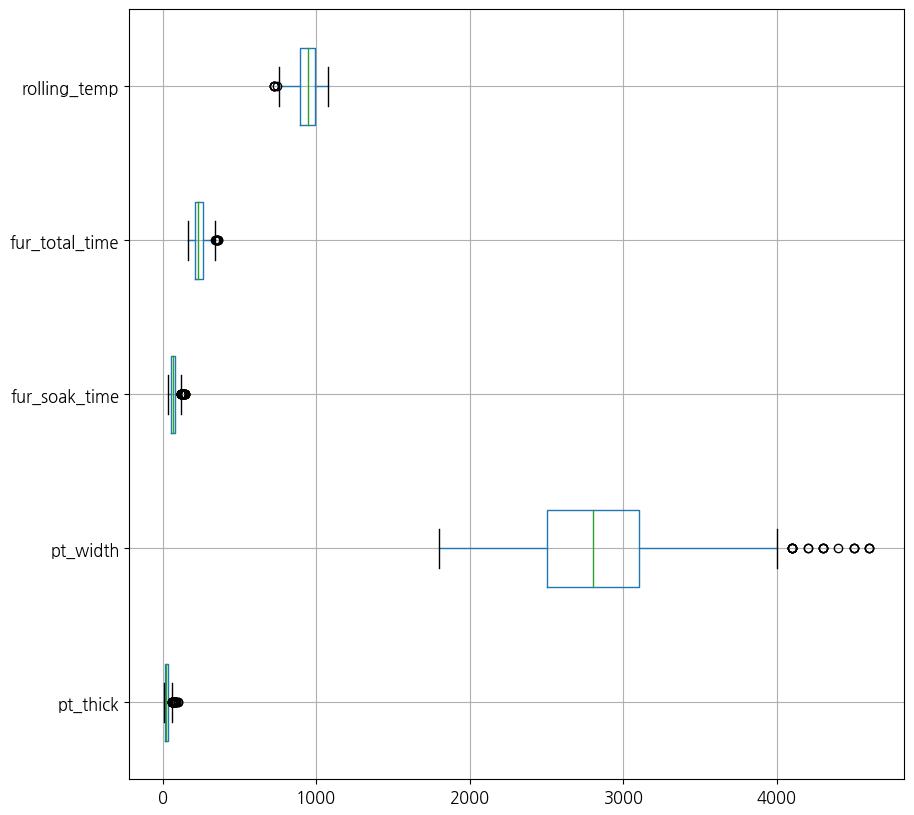

In [27]:
df_raw[out_lst].boxplot(figsize=(10,10),fontsize=12,vert=False)

- 후판 지시두께(pt_thick)
- 후판 지시폭(pt_width)
- 가열로 균열대 소재온도(fur_soak_time)
- 가열로 가열대 소재온도(fur_heat_temp), 
- 압연온도(rolling_temp)
- 수치형 변수들에 대해 단위가 달라 변수마다 box의 크기 차이가 큰 상황이다. → 수치형에 대해 scale 필요

array([[<Axes: title={'center': 'pt_thick'}>,
        <Axes: title={'center': 'pt_width'}>,
        <Axes: title={'center': 'pt_length'}>],
       [<Axes: title={'center': 'fur_heat_temp'}>,
        <Axes: title={'center': 'fur_heat_time'}>,
        <Axes: title={'center': 'fur_soak_temp'}>],
       [<Axes: title={'center': 'fur_soak_time'}>,
        <Axes: title={'center': 'fur_total_time'}>,
        <Axes: title={'center': 'fur_ex_temp'}>],
       [<Axes: title={'center': 'rolling_temp'}>, <Axes: >, <Axes: >]],
      dtype=object)

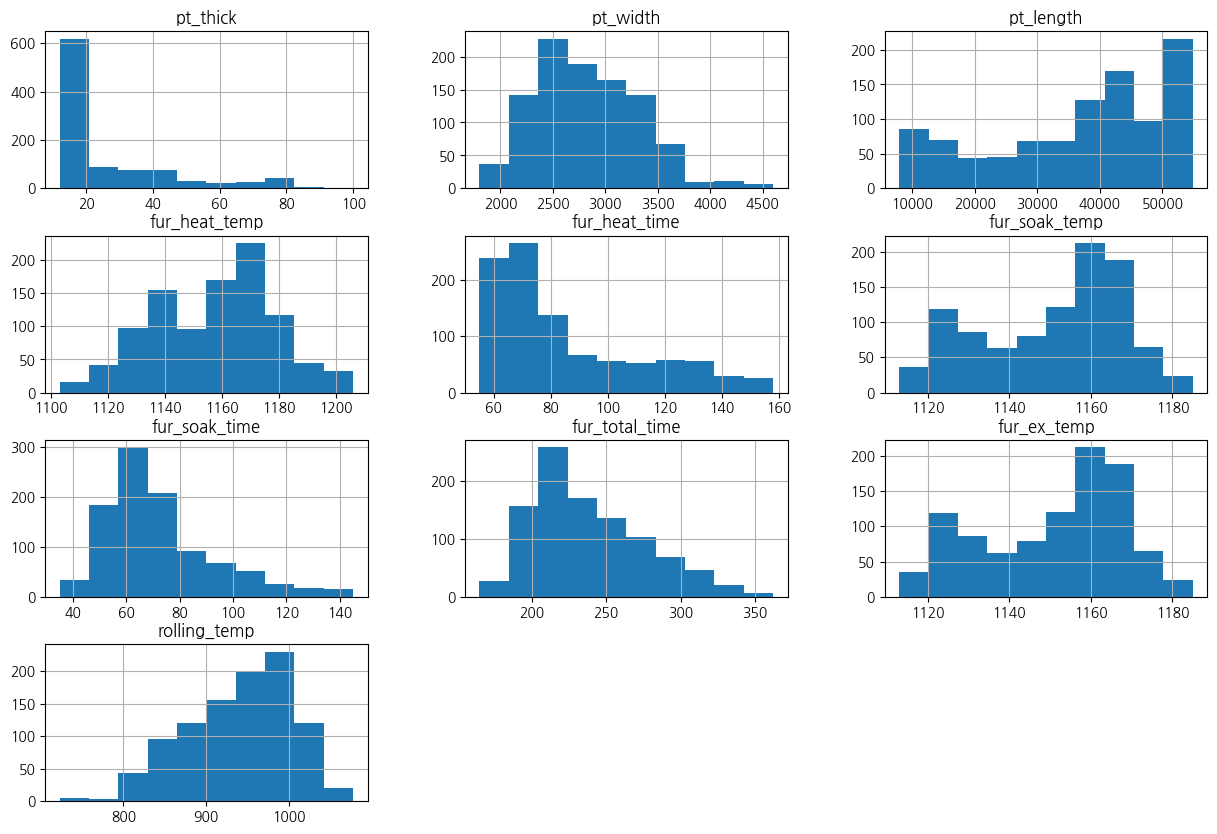

In [28]:
df_raw[con_cols].hist(figsize=(15, 10))

## 수치형 변수 scaling 하기
- 앞에서 본 Box Plot 결과에 의해 수치형 변수들을 scaling 실시

In [29]:
df_raw.head()

,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_method,rolling_temp,descaling_count,work_group
0,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,1호기,1열,1144,116,1133,59,259,1133,TMCP(온도제어),934,8,1조
1,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,1호기,2열,1144,122,1135,53,238,1135,TMCP(온도제어),937,8,1조
2,양품,NV-E36-TM,영국,T,33,3600,19200,적용,2호기,1열,1129,116,1121,55,258,1121,TMCP(온도제어),889,8,1조
3,양품,NV-E36-TM,영국,T,33,3600,19200,적용,2호기,2열,1152,125,1127,68,266,1127,TMCP(온도제어),885,8,1조
4,양품,BV-EH36-TM,프랑스,T,38,3100,13300,적용,3호기,1열,1140,134,1128,48,246,1128,TMCP(온도제어),873,8,1조


In [30]:
# 수치형, 명목형 자료 분할
df_target = df_raw['scale']
df_neumeric = df_raw[con_cols]
df_categorical = df_raw[cat_cols]

In [31]:
scaler = StandardScaler()
np_neumeric_scaled = scaler.fit_transform(df_neumeric)
df_neumeric_scaled = pd.DataFrame(np_neumeric_scaled,columns=df_neumeric.columns)

In [32]:
# df_neumeric_scaled, df_categorical 두 개의 index가 약간 상이했는지 join한 이후로 결측치가 발생해서
# index를 다시 세팅해주기로 했다.
df_target = df_target.reset_index(drop=True)
df_neumeric_scaled = df_neumeric_scaled.reset_index(drop=True)
df_categorical = df_categorical.reset_index(drop=True)

In [33]:
df_neumeric_scaled.head()

,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_temp
0,0.297380,1.758916,-1.568542,-0.629006,1.138138,-1.042290,-0.617512,0.531891,-1.042290,-0.098376
1,0.297380,1.758916,-1.568542,-0.629006,1.365628,-0.926564,-0.908186,-0.017312,-0.926564,-0.051371
2,0.352984,1.555807,-1.273013,-1.336122,1.138138,-1.736646,-0.811295,0.505738,-1.736646,-0.803452
3,0.352984,1.555807,-1.273013,-0.251878,1.479374,-1.389468,-0.181501,0.714959,-1.389468,-0.866125
4,0.631008,0.540262,-1.698287,-0.817571,1.820609,-1.331605,-1.150415,0.191908,-1.331605,-1.054145


In [34]:
df_categorical.head()

,spec_long,spec_country,steel_kind,hsb,fur_no,fur_input_row,rolling_method,work_group,descaling_count
0,AB/EH32-TM,미국,T,적용,1호기,1열,TMCP(온도제어),1조,8
1,AB/EH32-TM,미국,T,적용,1호기,2열,TMCP(온도제어),1조,8
2,NV-E36-TM,영국,T,적용,2호기,1열,TMCP(온도제어),1조,8
3,NV-E36-TM,영국,T,적용,2호기,2열,TMCP(온도제어),1조,8
4,BV-EH36-TM,프랑스,T,적용,3호기,1열,TMCP(온도제어),1조,8


In [35]:
df_scaled = pd.concat([df_target, df_neumeric_scaled, df_categorical], axis=1)

In [36]:
df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 994 entries, 0 to 993
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   scale            994 non-null    object 
 1   pt_thick         994 non-null    float64
 2   pt_width         994 non-null    float64
 3   pt_length        994 non-null    float64
 4   fur_heat_temp    994 non-null    float64
 5   fur_heat_time    994 non-null    float64
 6   fur_soak_temp    994 non-null    float64
 7   fur_soak_time    994 non-null    float64
 8   fur_total_time   994 non-null    float64
 9   fur_ex_temp      994 non-null    float64
 10  rolling_temp     994 non-null    float64
 11  spec_long        994 non-null    object 
 12  spec_country     994 non-null    object 
 13  steel_kind       994 non-null    object 
 14  hsb              994 non-null    object 
 15  fur_no           994 non-null    object 
 16  fur_input_row    994 non-null    object 
 17  rolling_method  

In [37]:
df_scaled.isna().sum()

scale              0
pt_thick           0
pt_width           0
pt_length          0
fur_heat_temp      0
fur_heat_time      0
fur_soak_temp      0
fur_soak_time      0
fur_total_time     0
fur_ex_temp        0
rolling_temp       0
spec_long          0
spec_country       0
steel_kind         0
hsb                0
fur_no             0
fur_input_row      0
rolling_method     0
work_group         0
descaling_count    0
dtype: int64

### scaling 결과
- 수치형 변수의 scaling 을 하였고
- 전체 데이터셋을 df_scale 으로 재지정함

<Axes: >

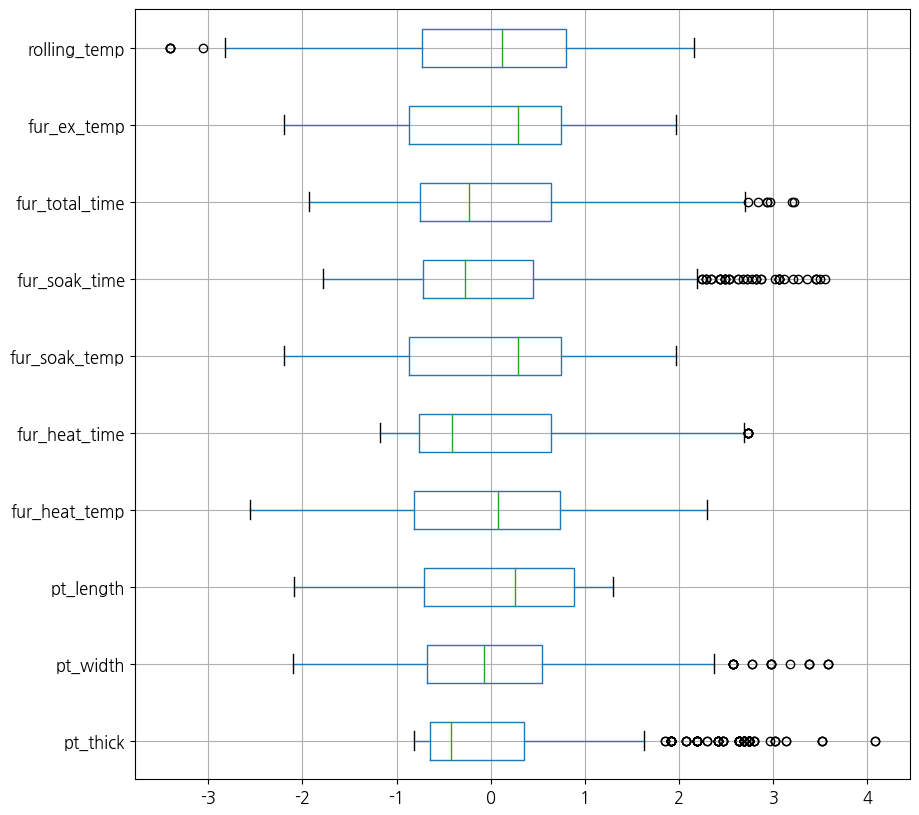

In [38]:
df_scaled.boxplot(figsize=(10,10),fontsize=12,vert=False)

# 그래프 분석

## 각 변수의 전체적인 분포 확인 (Histogram)

array([[<Axes: title={'center': 'pt_thick'}>,
        <Axes: title={'center': 'pt_width'}>,
        <Axes: title={'center': 'pt_length'}>],
       [<Axes: title={'center': 'fur_heat_temp'}>,
        <Axes: title={'center': 'fur_heat_time'}>,
        <Axes: title={'center': 'fur_soak_temp'}>],
       [<Axes: title={'center': 'fur_soak_time'}>,
        <Axes: title={'center': 'fur_total_time'}>,
        <Axes: title={'center': 'fur_ex_temp'}>],
       [<Axes: title={'center': 'rolling_temp'}>, <Axes: >, <Axes: >]],
      dtype=object)

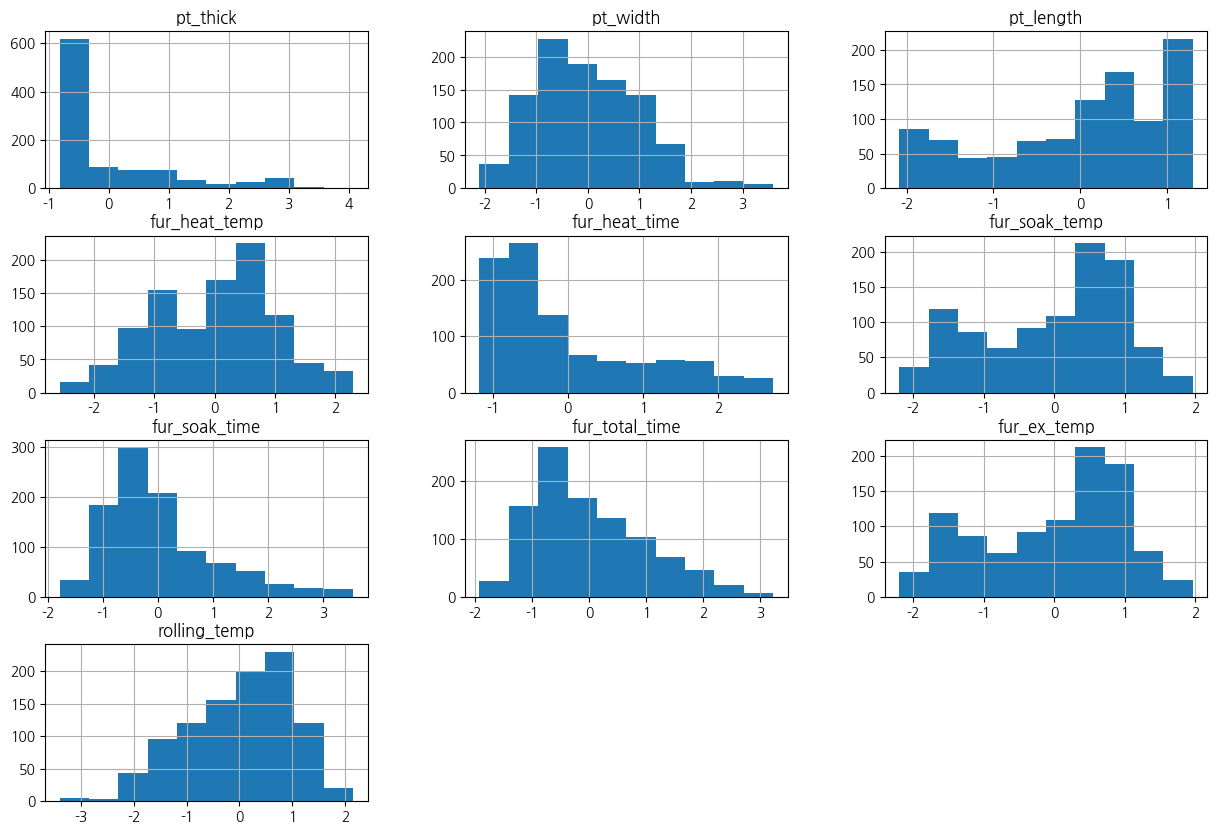

In [39]:
df_scaled.hist(figsize=(15, 10))

## 변수간 상관관계 확인

C:\Users\winju\AppData\Local\Temp\ipykernel_52248\1508976090.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_scaled.corr(),annot=True)


<Axes: >

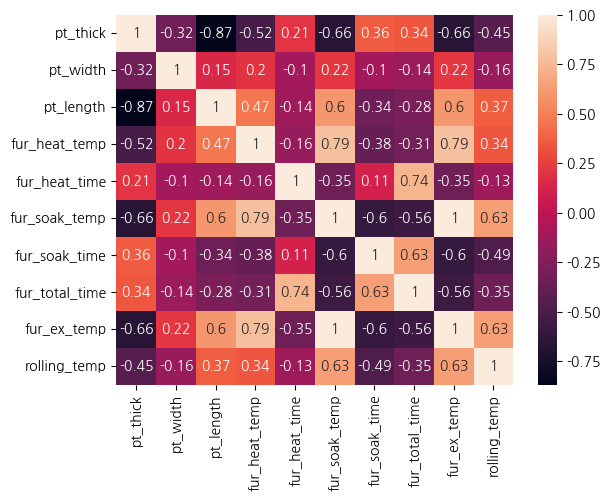

In [40]:
sns.heatmap(df_scaled.corr(),annot=True)

### 변수간 상관관계 결과 확인
- scaling 된 연속형 데이터 간 상관관계 확인결과
- **후판 지시두께와 후판 지시길이 간에 강한 음의 상관관계**가 있다.
- 후판 지시두께와 가열로 균열로 온도, 가열로 추출온도 와 약한 음의 상관관계가 있다.

- 후판 지시길이와 가열로 추출온도, 가열로 균열로 온도 와 약한 음의 상관관계가 있다.
- **가열로 가열대 온도와 가열대 추출온도, 균열대 온도 와 강한 상관관계**가 있다.
- **가열로 재로시간과 가열대 총 재로시간과 강한 상관관계**가 있다.
- 가열대 균열대 온도는 압연온도, 균열대 재로시간에 약한 상관관계가 있다.
- **가열대 균열대 온도는 가열대 추출온도와 매우 큰 상관성**을 보인다.
- 가열대 균열대 온도는 가열대 추출온도와 가열대 총 재로시간과 약한 상관관계가 있다.
- 가열대 추출온도는 압연온도와 약한 상관관계가 있다.

## scale 별 각 연속형 Histogram 분포비교

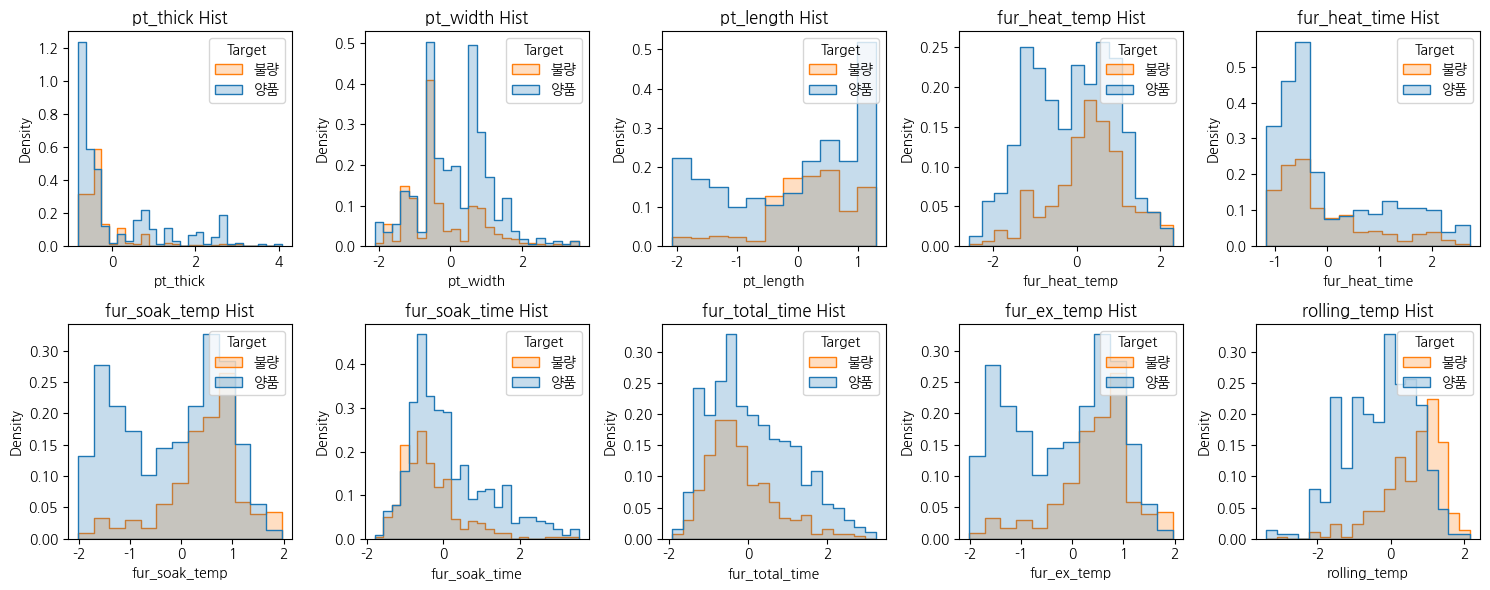

In [41]:
num_rows = 2  # 행 수
num_cols = 5  # 열 수
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 6))

# 각 연속형 변수에 대해 히스토그램 생성
for idx, column in enumerate(con_cols):
    row_idx = idx // num_cols  # 현재 행 인덱스
    col_idx = idx % num_cols   # 현재 열 인덱스
    
    ax = axes[row_idx, col_idx]  # 현재 서브플롯 선택
    sns.histplot(data=df_scaled, x=column, hue=df_raw['scale'], element='step', stat='density', ax=ax)
    
    ax.set_xlabel(column)
    ax.set_ylabel('Density')
    ax.set_title(f'{column} Hist')
    ax.legend(title='Target', labels=['불량', '양품'])

# 레이아웃 조정
plt.tight_layout()
plt.show()

## 강종과 scale 불량과의 관계

Text(0.5, 1.0, 'Tool Steel')

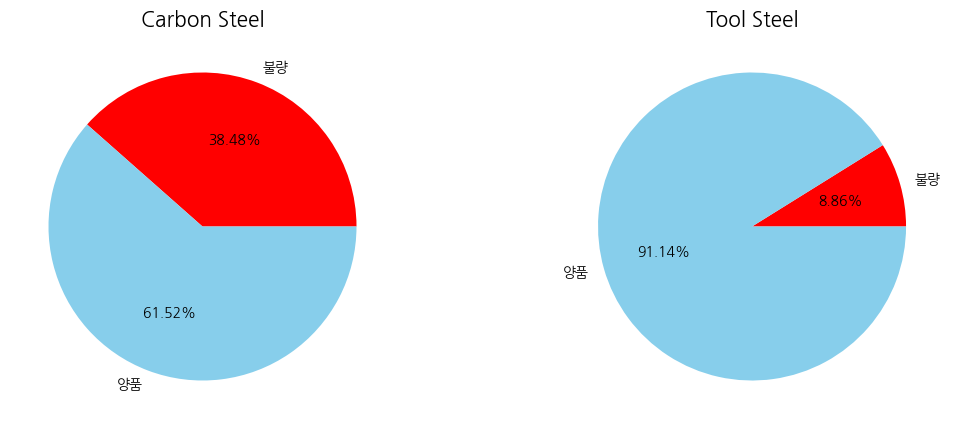

In [42]:
df_scaled_C = df_scaled[df_scaled["steel_kind"]=="C"]
df_scaled_T = df_scaled[df_scaled["steel_kind"]=="T"]

df_count1 = df_scaled_C.groupby(df_raw['scale']).size()
df_count2 = df_scaled_T.groupby(df_raw["scale"]).size()

scale = ["불량","양품"]
color = ['red','skyblue']

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (13, 5))

ax[0].pie(df_count1.to_numpy(), autopct="%.2f%%",labels=scale, colors=color)
ax[0].set_title("Carbon Steel", fontsize = 15)

ax[1].pie(df_count2.to_numpy(), autopct="%.2f%%",labels=scale, colors=color)
ax[1].set_title("Tool Steel", fontsize = 15)

- 금속 재료에 대한 불량률 확인 결과
- **Tool Steel(T)에 비해 Carbon Steel(C)의 불량비율이 더 높다.**
- 열처리와 경화, 다양한 형태로 가공 및 형성, 마모 저항성, 내부식성 처리 등에서 차이가 있는데
- 불량 원인 중 하나가 강종일 가능성이 존재한다.

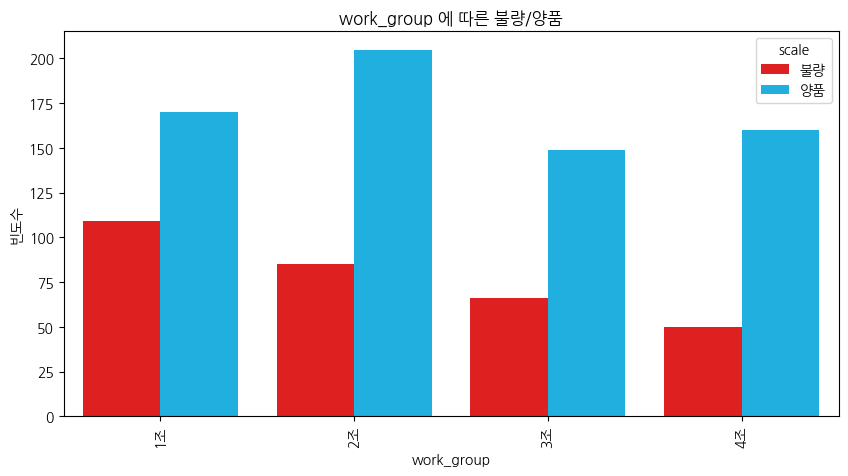

In [43]:
# 'scale' 열과 'work_group' 열을 기준으로 그룹화하여 빈도수 계산
grouped_counts = df_scaled.groupby(['scale', 'work_group']).size().reset_index(name='counts')

# 막대 그래프를 그립니다.
plt.figure(figsize=(10, 5))
sns.barplot(x='work_group', y='counts', hue='scale', data=grouped_counts, palette={'불량': 'red', '양품': 'deepskyblue'})
plt.xticks(rotation=90)
plt.xlabel('work_group')
plt.ylabel('빈도수')
plt.title('work_group 에 따른 불량/양품')
plt.show()

- 작업 조에 대한 불량률 확인 결과
- **작업 조별 불량비율이 약소하게 다르지만 목표변수 Scale데이터의 불량에 대해서는 설명할 수 없다.**

## Descaling 횟수와 scale 불량과의 관계

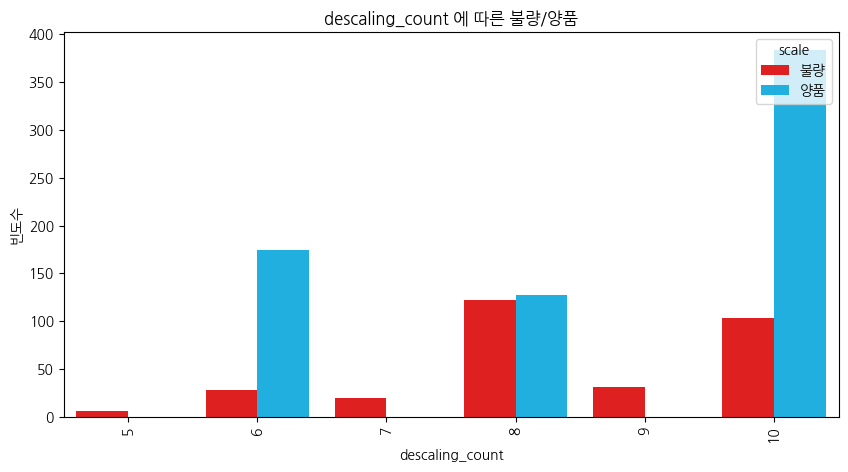

In [44]:
# 'scale' 열과 'descaling_count' 열을 기준으로 그룹화하여 빈도수 계산
grouped_counts = df_scaled.groupby(['scale', 'descaling_count']).size().reset_index(name='counts')

# 막대 그래프를 그립니다.
plt.figure(figsize=(10, 5))
sns.barplot(x='descaling_count', y='counts', hue='scale', data=grouped_counts, palette={'불량': 'red', '양품': 'deepskyblue'})
plt.xticks(rotation=90)
plt.xlabel('descaling_count')
plt.ylabel('빈도수')
plt.title('descaling_count 에 따른 불량/양품')
plt.show()

- descaling 횟수와 불량률의 관계를 직접적으로 찾기는 어렵다.
- **descaling 횟수는 scale 불량여부에 영향을 미치지 않을 것이라고 추정된다.**

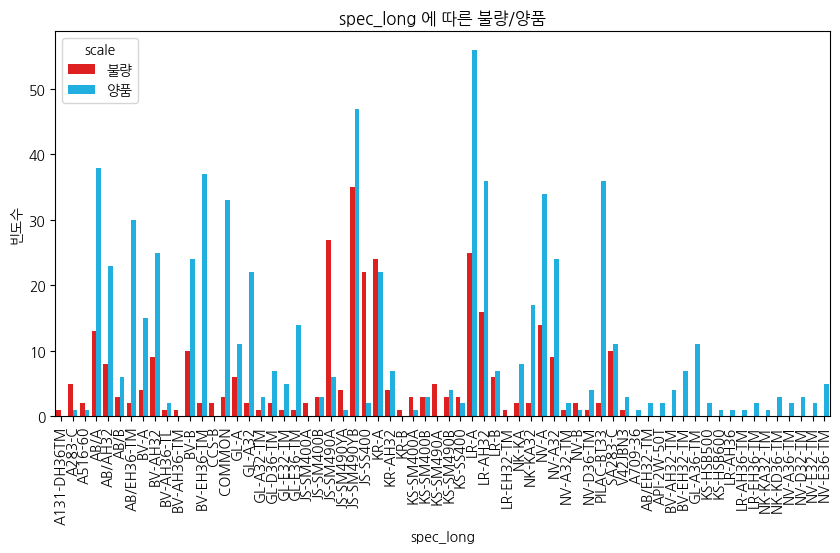

In [45]:
# 'scale' 열과 'spec_long' 열을 기준으로 그룹화하여 빈도수 계산
grouped_counts = df_scaled.groupby(['scale', 'spec_long']).size().reset_index(name='counts')

# 막대 그래프를 그립니다.
plt.figure(figsize=(10, 5))
sns.barplot(x='spec_long', y='counts', hue='scale', data=grouped_counts, palette={'불량': 'red', '양품': 'deepskyblue'})
plt.xticks(rotation=90)
plt.xlabel('spec_long')
plt.ylabel('빈도수')
plt.title('spec_long 에 따른 불량/양품')
plt.show()

- 제품 규격(spec_long)과 불량률의 관계를 직접적으로 찾기는 어렵다.
- **제품 규격은 scale 불량여부에 영향을 미치지 않을 것이라고 추정된다.**

## HSB 적용 여부에 따른 scale 불량 비율

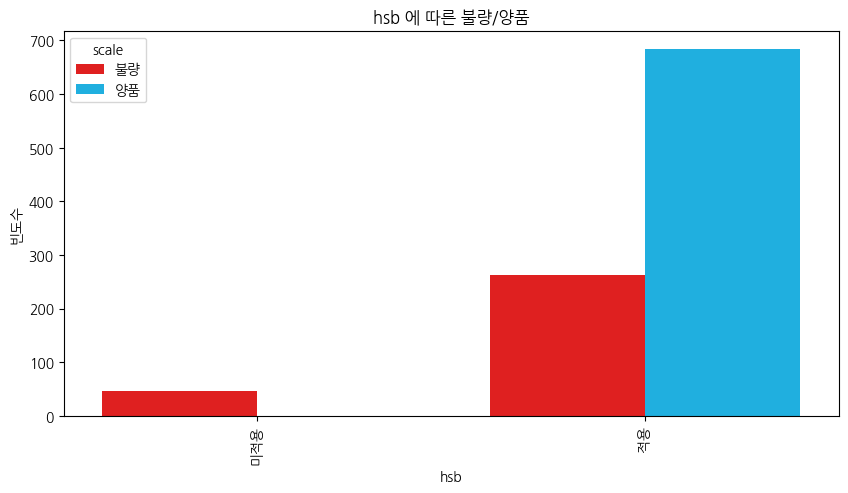

In [46]:
# 'scale' 열과 'descaling_count' 열을 기준으로 그룹화하여 빈도수 계산
grouped_counts = df_scaled.groupby(['scale', 'hsb']).size().reset_index(name='counts')

# 막대 그래프를 그립니다.
plt.figure(figsize=(10, 5))
sns.barplot(x='hsb', y='counts', hue='scale', data=grouped_counts, palette={'불량': 'red', '양품': 'deepskyblue'})
plt.xticks(rotation=90)
plt.xlabel('hsb')
plt.ylabel('빈도수')
plt.title('hsb 에 따른 불량/양품')
plt.show()

Text(0.5, 1.0, 'HSB 미적용')

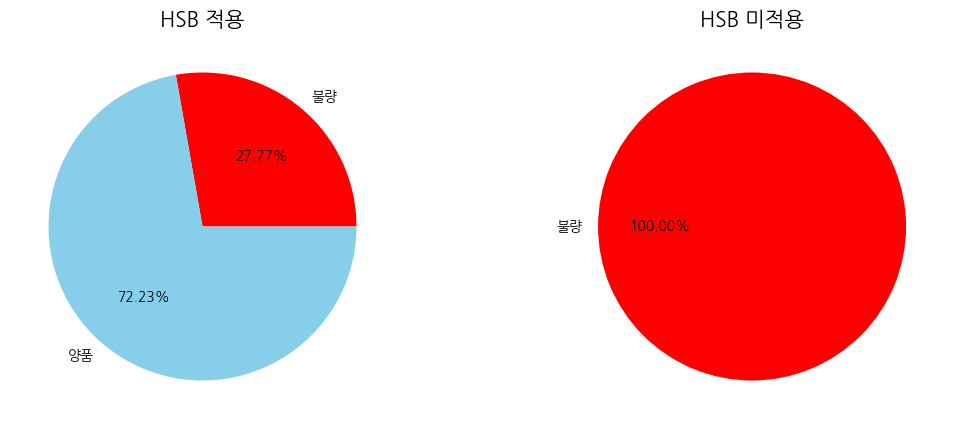

In [47]:
df_scaled_applied = df_scaled[df_scaled["hsb"]=="적용"]
df_scaled_Napplied = df_scaled[df_scaled["hsb"]=="미적용"]

df_count1 = df_scaled_applied.groupby(["scale"]).size()
df_count2 = df_scaled_Napplied.groupby(["scale"]).size()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))

color = ['red','skyblue']

# HSB가 "적용"되었을 때의 파이 차트
ax[0].pie(df_count1.to_numpy(), autopct="%.2f%%", labels=df_count1.index, colors=color)
ax[0].set_title("HSB 적용", fontsize=15)

# HSB가 "미적용"일 때의 파이 차트
ax[1].pie(df_count2.to_numpy(), autopct="%.2f%%", labels=df_count2.index, colors=color)
ax[1].set_title("HSB 미적용", fontsize=15)

- HSB 에 대해 미적용시 모두 불량이지만, **HSB를 적용하면 상대적으로 불량 비율이 적어진다.**
- 불량 원인 중 하나가 HSB 미적용일 가능성이 존재한다.

## 가열로 온도 및 시간 변수와 scale 불량과의 관계

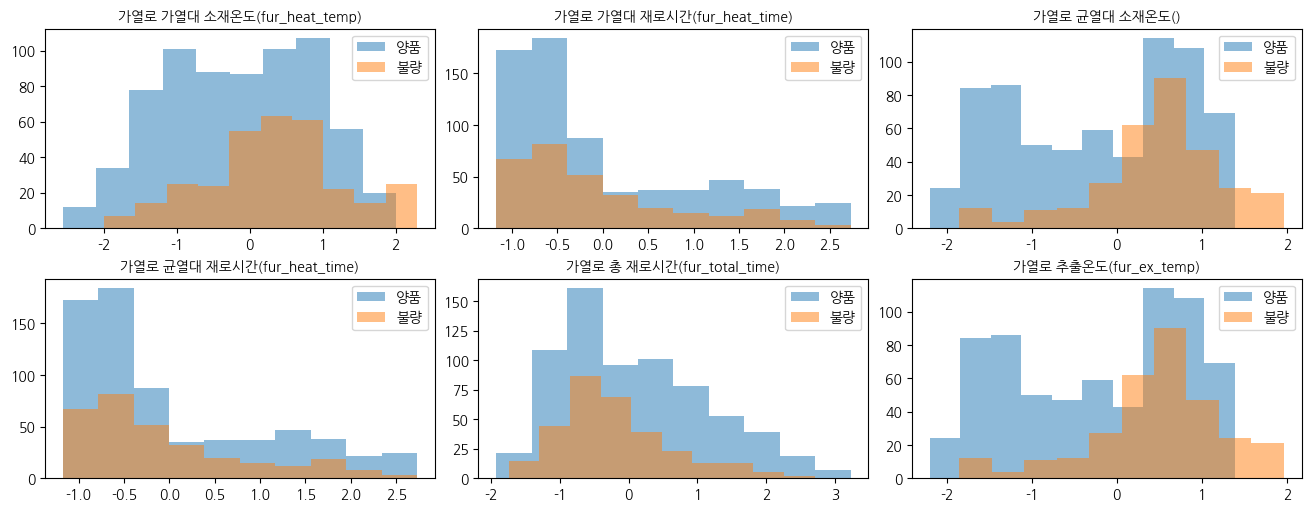

In [48]:
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (13, 5),constrained_layout=True)

ax[0][0].hist(df_scaled[df_scaled["scale"] == "양품"]["fur_heat_temp"], label = "양품", alpha = 0.5)
ax[0][0].hist(df_scaled[df_scaled["scale"] == "불량"]["fur_heat_temp"], label = "불량", alpha = 0.5)
ax[0][0].set_title("가열로 가열대 소재온도(fur_heat_temp)", fontsize = 10)
ax[0][0].legend()

ax[0][1].hist(df_scaled[df_scaled["scale"] == "양품"]["fur_heat_time"], label = "양품", alpha = 0.5)
ax[0][1].hist(df_scaled[df_scaled["scale"] == "불량"]["fur_heat_time"], label = "불량", alpha = 0.5)
ax[0][1].set_title("가열로 가열대 재로시간(fur_heat_time)", fontsize = 10)
ax[0][1].legend()

ax[0][2].hist(df_scaled[df_scaled["scale"] == "양품"]["fur_soak_temp"], label = "양품", alpha = 0.5)
ax[0][2].hist(df_scaled[df_scaled["scale"] == "불량"]["fur_soak_temp"], label = "불량", alpha = 0.5)
ax[0][2].set_title("가열로 균열대 소재온도()", fontsize = 10)
ax[0][2].legend()

ax[1][0].hist(df_scaled[df_scaled["scale"] == "양품"]["fur_heat_time"], label = "양품", alpha = 0.5)
ax[1][0].hist(df_scaled[df_scaled["scale"] == "불량"]["fur_heat_time"], label = "불량", alpha = 0.5)
ax[1][0].set_title("가열로 균열대 재로시간(fur_heat_time)", fontsize = 10)
ax[1][0].legend()

ax[1][1].hist(df_scaled[df_scaled["scale"] == "양품"]["fur_total_time"], label = "양품", alpha = 0.5)
ax[1][1].hist(df_scaled[df_scaled["scale"] == "불량"]["fur_total_time"], label = "불량", alpha = 0.5)
ax[1][1].set_title("가열로 총 재로시간(fur_total_time)", fontsize = 10)
ax[1][1].legend()

ax[1][2].hist(df_scaled[df_scaled["scale"] == "양품"]["fur_ex_temp"], label = "양품", alpha = 0.5)
ax[1][2].hist(df_scaled[df_scaled["scale"] == "불량"]["fur_ex_temp"], label = "불량", alpha = 0.5)
ax[1][2].set_title("가열로 추출온도(fur_ex_temp)", fontsize = 10)
ax[1][2].legend()

- **온도** 관련변수(가열대 소재온도, 균열대 소재온도, 가열로 추출온도)는 그 값이 **커질수록 불량 수가 증가**하는 경향이 있다.  
- **시간** 관련변수(가열대 재로시간, 균열대 재로시간, 가열로 총 재로시간)는 그 값이 **작을수록 불량 수가 증가**하는 경향이 있다.
- 즉, 온도를 높일수록 불량률은 올라가며 시간을 재로시간을 짧게 할수록 불량률이 올라가므로
- 온도는 일정범위 기준이상 올리지말고 시간은 일정시간 이상으로 충분히 확보해야 불량률을 줄일 수 있다.
- 온도 변수와 시간 변수는 분포들이 비슷하므로 상당한 상관관계가 있을 것이라 추정된다.

## 압연온도와 scale 불량과의 관계

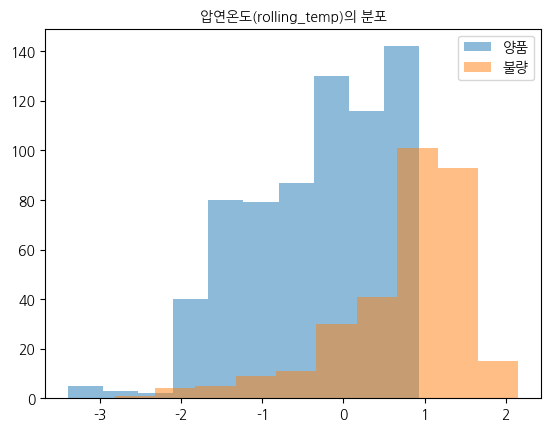

In [49]:
plt.hist(df_scaled[df_scaled["scale"] == "양품"]["rolling_temp"], label = "양품", alpha = 0.5)
plt.hist(df_scaled[df_scaled["scale"] == "불량"]["rolling_temp"], label = "불량", alpha = 0.5)
plt.title("압연온도(rolling_temp)의 분포", fontsize = 10)
plt.legend()

- 압연온도가 **높아질수록 불량 수가 증가**하는 경향이 있다.
- 압연온도 scaling 기준 1에서 불량률이 매우 높으므로 압연온도를 이 수준 이상 올리면 안된다

## plate의 두께, 너비, 길이, 무게와 scale 불량과의 관계

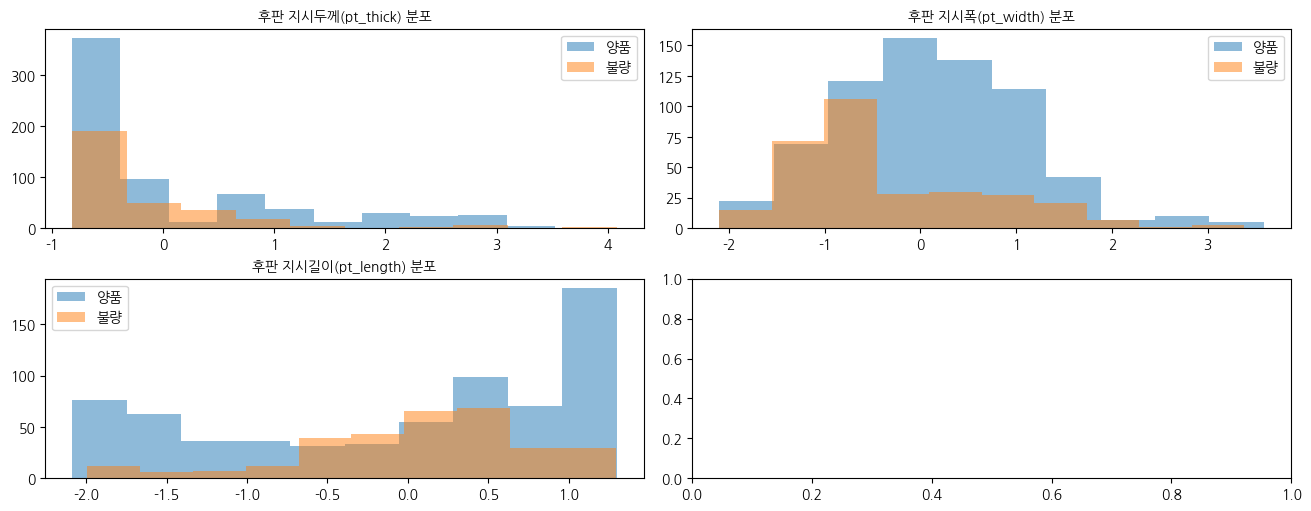

In [50]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (13, 5),constrained_layout=True)

ax[0][0].hist(df_scaled[df_scaled["scale"] == "양품"]["pt_thick"], label = "양품", alpha = 0.5)
ax[0][0].hist(df_scaled[df_scaled["scale"] == "불량"]["pt_thick"], label = "불량", alpha = 0.5)
ax[0][0].set_title("후판 지시두께(pt_thick) 분포", fontsize = 10)
ax[0][0].legend()

ax[0][1].hist(df_scaled[df_scaled["scale"] == "양품"]["pt_width"], label = "양품", alpha = 0.5)
ax[0][1].hist(df_scaled[df_scaled["scale"] == "불량"]["pt_width"], label = "불량", alpha = 0.5)
ax[0][1].set_title("후판 지시폭(pt_width) 분포", fontsize = 10)
ax[0][1].legend()

ax[1][0].hist(df_scaled[df_scaled["scale"] == "양품"]["pt_length"], label = "양품", alpha = 0.5)
ax[1][0].hist(df_scaled[df_scaled["scale"] == "불량"]["pt_length"], label = "불량", alpha = 0.5)
ax[1][0].set_title("후판 지시길이(pt_length) 분포", fontsize = 10)
ax[1][0].legend()

- **후판의 지시두께가 평균 아래에서 얇을수록 불량 수가 증가**하는 경향이 있다.
- **후판의 지시폭이 평균 아래에서 좁아질수록 불량 수가 급격히 증가**하는 경향이 있다.
- **후판의 지시길이가 평균에서 가까울수록 불량 수가 증가**하는 경향이 있다.
- 후판 지시두께와 지시폭의 분포는 비슷한 형태를 띠고있다

## 추가적인 변수 삭제

In [51]:
# 앞에서 봤듯이 ROLLING_DESCALING은 SCALE에 큰 영향을 미치지 않는 것으로 판단되어 삭제하기로 했다. 
# 또한 WORK_GR, FUR_NO, FUR_NO_ROW, SPEC도 중요변수라한들 개선 방안 혹은 해결책을 제시하기는 어렵다고 판단하여 삭제하기로 했다.
df_scaled.drop(["descaling_count",'spec_long'],axis=1,inplace=True)
df_scaled.head()

,scale,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_temp,spec_country,steel_kind,hsb,fur_no,fur_input_row,rolling_method,work_group
0,양품,0.297380,1.758916,-1.568542,-0.629006,1.138138,-1.042290,-0.617512,0.531891,-1.042290,-0.098376,미국,T,적용,1호기,1열,TMCP(온도제어),1조
1,양품,0.297380,1.758916,-1.568542,-0.629006,1.365628,-0.926564,-0.908186,-0.017312,-0.926564,-0.051371,미국,T,적용,1호기,2열,TMCP(온도제어),1조
2,양품,0.352984,1.555807,-1.273013,-1.336122,1.138138,-1.736646,-0.811295,0.505738,-1.736646,-0.803452,영국,T,적용,2호기,1열,TMCP(온도제어),1조
3,양품,0.352984,1.555807,-1.273013,-0.251878,1.479374,-1.389468,-0.181501,0.714959,-1.389468,-0.866125,영국,T,적용,2호기,2열,TMCP(온도제어),1조
4,양품,0.631008,0.540262,-1.698287,-0.817571,1.820609,-1.331605,-1.150415,0.191908,-1.331605,-1.054145,프랑스,T,적용,3호기,1열,TMCP(온도제어),1조


# 모델 선정

## 로지스틱 회귀분석

In [52]:
df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 994 entries, 0 to 993
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   scale           994 non-null    object 
 1   pt_thick        994 non-null    float64
 2   pt_width        994 non-null    float64
 3   pt_length       994 non-null    float64
 4   fur_heat_temp   994 non-null    float64
 5   fur_heat_time   994 non-null    float64
 6   fur_soak_temp   994 non-null    float64
 7   fur_soak_time   994 non-null    float64
 8   fur_total_time  994 non-null    float64
 9   fur_ex_temp     994 non-null    float64
 10  rolling_temp    994 non-null    float64
 11  spec_country    994 non-null    object 
 12  steel_kind      994 non-null    object 
 13  hsb             994 non-null    object 
 14  fur_no          994 non-null    object 
 15  fur_input_row   994 non-null    object 
 16  rolling_method  994 non-null    object 
 17  work_group      994 non-null    obj

In [53]:
from sklearn.preprocessing import LabelEncoder
# 레이블 인코더 객체 생성
label_encoder = LabelEncoder()
# 해당 변수 더미화 실시
df_scaled['scale'] = label_encoder.fit_transform(df_scaled['scale'])

# # cat_cols에 있는 각 범주형 변수들에 대해 for 문 레이블 인코딩 수행
# for col in cat_cols:
#     df_raw[col] = label_encoder.fit_transform(df_raw[col])
# # 결과 확인

df_scaled.head(10)

,scale,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_temp,spec_country,steel_kind,hsb,fur_no,fur_input_row,rolling_method,work_group
0,1,0.297380,1.758916,-1.568542,-0.629006,1.138138,-1.042290,-0.617512,0.531891,-1.042290,-0.098376,미국,T,적용,1호기,1열,TMCP(온도제어),1조
1,1,0.297380,1.758916,-1.568542,-0.629006,1.365628,-0.926564,-0.908186,-0.017312,-0.926564,-0.051371,미국,T,적용,1호기,2열,TMCP(온도제어),1조
2,1,0.352984,1.555807,-1.273013,-1.336122,1.138138,-1.736646,-0.811295,0.505738,-1.736646,-0.803452,영국,T,적용,2호기,1열,TMCP(온도제어),1조
3,1,0.352984,1.555807,-1.273013,-0.251878,1.479374,-1.389468,-0.181501,0.714959,-1.389468,-0.866125,영국,T,적용,2호기,2열,TMCP(온도제어),1조
4,1,0.631008,0.540262,-1.698287,-0.817571,1.820609,-1.331605,-1.150415,0.191908,-1.331605,-1.054145,프랑스,T,적용,3호기,1열,TMCP(온도제어),1조
5,1,0.631008,0.540262,-1.698287,-0.676147,1.555204,-1.331605,-0.714403,0.427281,-1.331605,-1.038477,프랑스,T,적용,3호기,2열,TMCP(온도제어),1조
6,1,0.631008,0.540262,-1.453214,-0.911853,1.517289,-1.215879,-1.053523,1.028789,-1.215879,-0.975804,프랑스,T,적용,1호기,1열,TMCP(온도제어),1조
7,1,0.631008,0.540262,-1.453214,-0.864712,1.517289,-1.158016,-0.956632,0.871874,-1.158016,-1.101150,프랑스,T,적용,1호기,2열,TMCP(온도제어),1조
8,1,0.631008,0.540262,-1.453214,-1.430405,1.517289,-1.678783,-0.956632,0.061145,-1.678783,-1.054145,프랑스,T,적용,2호기,1열,TMCP(온도제어),1조
9,0,0.631008,0.540262,-1.489254,-1.053276,1.251883,-1.563057,0.060728,1.342619,-1.563057,-0.928799,미국,T,적용,2호기,2열,TMCP(온도제어),1조


In [54]:
df_train, df_test = train_test_split(df_scaled, test_size = 0.4, random_state = 1234)

print("train data shape: ", df_train.shape)
print("test data shape: ", df_test.shape)

train data shape:  (596, 18)
test data shape:  (398, 18)


### 로지스틱 회귀모델 생성

C:\Users\winju\AppData\Local\Temp\ipykernel_52248\1671885610.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_scaled.corr(), annot=True)


<Axes: >

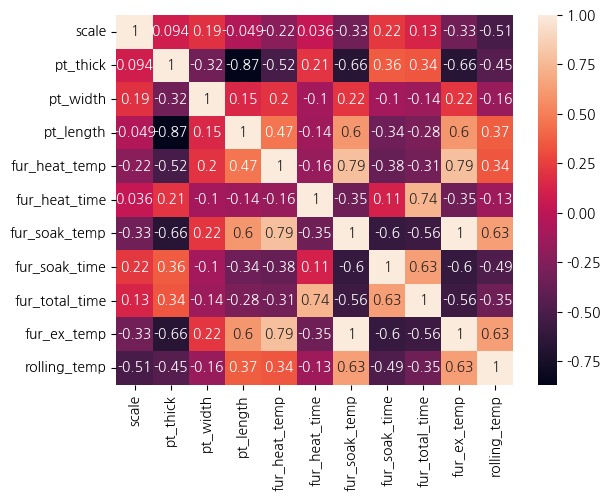

In [55]:
sns.heatmap(df_scaled.corr(), annot=True)

### 변수간 상관관계 결과 확인
- scaling 된 연속형 데이터 간 상관관계 확인결과
- **후판 지시두께와 후판 지시길이 간에 강한 음의 상관관계**가 있다.
- 후판 지시두께와 가열로 균열로 온도, 가열로 추출온도 와 약한 음의 상관관계가 있다.

- 후판 지시길이와 가열로 추출온도, 가열로 균열로 온도 와 약한 음의 상관관계가 있다.
- **가열로 가열대 온도와 가열대 추출온도, 균열대 온도 와 강한 상관관계**가 있다.
- **가열로 재로시간과 가열대 총 재로시간과 강한 상관관계**가 있다.
- 가열대 균열대 온도는 압연온도, 균열대 재로시간에 약한 상관관계가 있다.
- **가열대 균열대 온도는 가열대 추출온도와 매우 큰 상관성**을 보인다.
- 가열대 균열대 온도는 가열대 추출온도와 가열대 총 재로시간과 약한 상관관계가 있다.
- 가열대 추출온도는 압연온도와 약한 상관관계가 있다.

- 후판 지시두께는 후판 지시길이와 강한 상관관계가 있다.
- 후판 지시두께와 지시길이는 가열로 온도와 약한 음의 상관관계가 있다.

- 가열대 가열로 온도는 가열대 추출온도와 균열대 온도에 강한 상관관계가 있다.
- 가열대 균열대 온도는 가열대 추출온도에 큰 상관성을 가지므로 삭제한다
- 즉, 가열대 가열로, 균열대, 추출 온도 중 추출온도와 총 재로시간을 제외하고 삭제한다.

In [56]:
log_model = sm.Logit.from_formula("scale ~ pt_thick + pt_width + pt_width + fur_total_time + fur_ex_temp + rolling_temp + C(spec_country) + C(steel_kind) + C(hsb) + C(fur_input_row) + C(rolling_method)", df_train)
log_result = log_model.fit()
print(log_result.summary())

         Current function value: 0.304798
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                  scale   No. Observations:                  596
Model:                          Logit   Df Residuals:                      580
Method:                           MLE   Df Model:                           15
Date:                Wed, 09 Aug 2023   Pseudo R-squ.:                  0.5111
Time:                        23:46:43   Log-Likelihood:                -181.66
converged:                      False   LL-Null:                       -371.54
Covariance Type:            nonrobust   LLR p-value:                 1.233e-71
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                         -61.4181   1.01e+05     -0.001      1.000   -1.97e+05    1.97e+05
C(

C:\Users\winju\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1. Pseudo R-squ.: 0.5111  
이 기본 설정으로 만들어진 로지스틱 회귀 모델은 **약 51% 정도 설명 가능**하다.

2. **후판 지시두께, 후판 지시폭, 가열로 총 재로시간, 가열로 총 온도, 압연온도**의 P>|t|는 유의수준(0.05)보다 작다.  
이 변수들이 유의한 변수이다.

### 모델 예측 및 성능 평가

In [57]:
# test 데이터 예측
y_pred = log_result.predict(df_test)

# 0과 1의 값을 가진 class로 변환
y_pred_class = (y_pred > 0.5).astype(int)
y_pred_class.head()

765    0
980    1
947    1
777    1
202    0
dtype: int32

In [58]:
print("총 test-set 개수:",y_pred_class.count())
a_0 = y_pred_class == 0
print("양품으로 예측한 개수:",a_0.sum())
a_1 = y_pred_class == 1
print("불량으로 예측한 개수",a_1.sum())

총 test-set 개수: 398
양품으로 예측한 개수: 113
불량으로 예측한 개수 285


In [59]:
# 실제 test 데이터의 목표변수와 test 데이터의 예측값 비교
print("Accuracy: {0:.3f}\n".format(accuracy_score(df_test["scale"], y_pred_class)))
print("Confusion Matrix: \n{}".format(confusion_matrix(df_test["scale"], y_pred_class)))

Accuracy: 0.862

Confusion Matrix: 
[[ 90  32]
 [ 23 253]]


1. 이 모델의 예측 정확도는 0.862이다. **즉, 86.2% 정도는 정답을 맞춘다.**
2. precision은 253/(253 + 32) = 253/285 ≓ 0.88 이다. **즉, 불량이라고 예측한 것 중에 맞춘 비율은 약 88%이다.**
3. recall은 253/(23 + 253) = 253/286 ≓ 0.92 이다. **즉, 실제로 불량인 것 중에 예측을 맞춘 비율은 약 92%이다.**
4. precision이 더 중요한지 아니면 recall이 더 중요한지는 해당 기업에 어느 부분에 더 가치를 두는지에 따라 달라진다.
- '1 - precision' : 불량이라고 예측했다. 그래서 보수를 했다. 근데 알고보니 불량이 아니다. 이에 대한 비용이 발생했다.
- '1 - recall' : 실제 불량인데 정상이라고 판단해서 보낸 물품. 소비자가 불만을 가지고 추후에 해당 제품을 사용하지 않을 수도 있다.
- 즉, 불량률에 관심이 많은 recall 지표가 0.92 인 것은 의미가 있다고 할 수 있다.

### 모델이 말하는 중요한 변수

<Axes: >

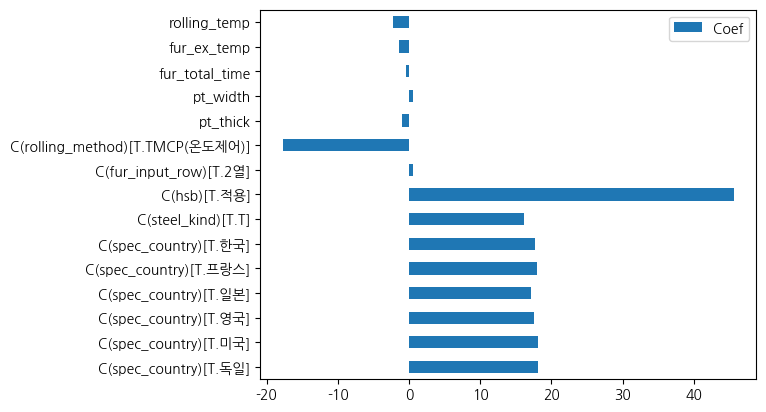

In [60]:
# 설명변수 중요도
df_logistic_coef = pd.DataFrame({"Coef": log_result.params.values[1:]}, index = log_model.exog_names[1:])

df_logistic_coef.plot.barh(y = "Coef")

HSB 적용 여부 , 제품 규격 기준국(spec_country) , 압연방법(rolling_method) 순으로 scale 불량에 영향을 많이 미치는 것으로 나타났다.
- **HSB 과정을 "진행하지 않았을 때" scale 불량일 가능성이 높다.**
- **제품 규격기준이 한국, 프랑스, 일본, 영국, 미국, 독일 에서 불량 가능서이 낮다**
- **rolling_method 가 TMCP(온도제어)" 일 때 불량일 가능성이 높다.**
- **압연온도가 "높을수록" scale 불량일 가능성이 높다.**
- **가열로 균열대 온도가 "높을수록" scale 불량일 가능성이 높다.**

## Random Forest (Classifier)

### 목표변수, 설명변수 분리

In [61]:
df_scaled_x = df_scaled.drop("scale",axis=1)
df_scaled_y = df_scaled["scale"]
df_scaled_x.head()

,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_temp,spec_country,steel_kind,hsb,fur_no,fur_input_row,rolling_method,work_group
0,0.297380,1.758916,-1.568542,-0.629006,1.138138,-1.042290,-0.617512,0.531891,-1.042290,-0.098376,미국,T,적용,1호기,1열,TMCP(온도제어),1조
1,0.297380,1.758916,-1.568542,-0.629006,1.365628,-0.926564,-0.908186,-0.017312,-0.926564,-0.051371,미국,T,적용,1호기,2열,TMCP(온도제어),1조
2,0.352984,1.555807,-1.273013,-1.336122,1.138138,-1.736646,-0.811295,0.505738,-1.736646,-0.803452,영국,T,적용,2호기,1열,TMCP(온도제어),1조
3,0.352984,1.555807,-1.273013,-0.251878,1.479374,-1.389468,-0.181501,0.714959,-1.389468,-0.866125,영국,T,적용,2호기,2열,TMCP(온도제어),1조
4,0.631008,0.540262,-1.698287,-0.817571,1.820609,-1.331605,-1.150415,0.191908,-1.331605,-1.054145,프랑스,T,적용,3호기,1열,TMCP(온도제어),1조


In [62]:
df_scaled_y.head()

0    1
1    1
2    1
3    1
4    1
Name: scale, dtype: int32

### 더미변수 생성

In [63]:
# get_dummies: 데이터의 문자형 변수에 대한 더미변수 생성 
df_scaled_x_dummy = pd.get_dummies(df_scaled_x)

# 더미변수 생성된 데이터의 상위 5개 row를 확인
df_scaled_x_dummy.head()

,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_temp,...,fur_no_2호기,fur_no_3호기,fur_input_row_1열,fur_input_row_2열,rolling_method_CR(제어압연),rolling_method_TMCP(온도제어),work_group_1조,work_group_2조,work_group_3조,work_group_4조
0,0.297380,1.758916,-1.568542,-0.629006,1.138138,-1.042290,-0.617512,0.531891,-1.042290,-0.098376,...,0,0,1,0,0,1,1,0,0,0
1,0.297380,1.758916,-1.568542,-0.629006,1.365628,-0.926564,-0.908186,-0.017312,-0.926564,-0.051371,...,0,0,0,1,0,1,1,0,0,0
2,0.352984,1.555807,-1.273013,-1.336122,1.138138,-1.736646,-0.811295,0.505738,-1.736646,-0.803452,...,1,0,1,0,0,1,1,0,0,0
3,0.352984,1.555807,-1.273013,-0.251878,1.479374,-1.389468,-0.181501,0.714959,-1.389468,-0.866125,...,1,0,0,1,0,1,1,0,0,0
4,0.631008,0.540262,-1.698287,-0.817571,1.820609,-1.331605,-1.150415,0.191908,-1.331605,-1.054145,...,0,1,1,0,0,1,1,0,0,0


### train, test 데이터 분할

In [64]:
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_scaled_x_dummy, df_scaled_y, test_size = 0.4, random_state = 1234)
print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("test data X size : {}".format(df_test_x.shape))
print("test data Y size : {}".format(df_test_y.shape))

train data X size : (596, 32)
train data Y size : (596,)
test data X size : (398, 32)
test data Y size : (398,)


### 기본 옵션으로 랜덤포레스트 생성

In [65]:
rf_uncustomized = RandomForestClassifier()
rf_uncustomized.fit(df_train_x,df_train_y)

#train data 설명력 (결정계수 확인)
print("score on training set :{:.3f}".format(rf_uncustomized.score(df_train_x,df_train_y)))

#test data 설명력 (결정계수 확인)
print("score on test set :{:.3f}".format(rf_uncustomized.score(df_test_x,df_test_y)))

print(rf_uncustomized)

score on training set :1.000
score on test set :0.955
RandomForestClassifier()


- test-set의 설명력이 높지만 train-set의 설명력이 1이므로 over-fitting이다.

### n_estimators 값에 따라 비교

In [66]:
# train 및 test 설명력 결과 저장
train_score = [];test_score=[]
para_n_tree = [n_tree * 5 for n_tree in range(1,11)]

for v_n_estimators in para_n_tree:
    rf = RandomForestClassifier(n_estimators=v_n_estimators)
    rf.fit(df_train_x,df_train_y)
    train_score.append(rf.score(df_train_x,df_train_y))
    test_score.append(rf.score(df_test_x,df_test_y))
    
df_score_n = pd.DataFrame()
df_score_n["n_estimators"] = para_n_tree
df_score_n["TrainScore"] = train_score
df_score_n["TestScore"] = test_score

df_score_n.round(3)

,n_estimators,TrainScore,TestScore
0,5,0.993,0.935
1,10,0.995,0.925
2,15,0.993,0.950
3,20,0.998,0.957
4,25,0.993,0.957
5,30,0.998,0.960
6,35,1.000,0.955
7,40,1.000,0.952
8,45,1.000,0.952
9,50,1.000,0.957


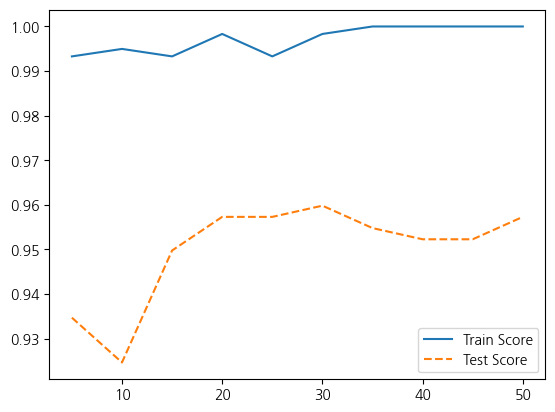

In [67]:
# 모델 설명력 확인 그래프
plt.plot(para_n_tree,train_score,linestyle="-",label="Train Score")
plt.plot(para_n_tree,test_score,linestyle="--",label="Test Score")
plt.legend()

- test 정확도가 적절하게 높으면서 over-fitting을 방지하기 위해 n_estimator = 25 정도로 선택

### min_samples_leaf 값에 따라 비교

In [68]:
# train 및 test 설명력 결과 저장
train_score = [];test_score=[]
para_leaf = [n_leaf * 1 for n_leaf in range(1,21)]

for v_min_samples_leaf in para_leaf:
    rf = RandomForestClassifier(n_estimators=25,min_samples_leaf=v_min_samples_leaf)
    rf.fit(df_train_x,df_train_y)
    train_score.append(rf.score(df_train_x,df_train_y))
    test_score.append(rf.score(df_test_x,df_test_y))
    
df_score_leaf = pd.DataFrame()
df_score_leaf["MinSamplesLeaf"] = para_leaf
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score

df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,0.998,0.952
1,2,0.965,0.957
2,3,0.958,0.960
3,4,0.958,0.962
4,5,0.953,0.950
5,6,0.941,0.957
6,7,0.955,0.952
7,8,0.953,0.960
8,9,0.950,0.960
9,10,0.936,0.930


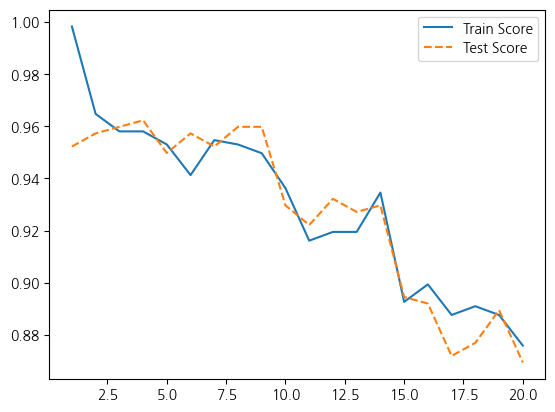

In [69]:
# 모델 설명력 확인 그래프
plt.plot(para_leaf,train_score,linestyle="-",label="Train Score")
plt.plot(para_leaf,test_score,linestyle="--",label="Test Score")
plt.legend()

- leaf node에 들어가는 데이터 수가 너무 적으면 over-fitting 되므로 min_samples_leaf = 7로 선택

### min_samples_split 값에 따라 비교

In [70]:
# train 및 test 설명력 결과 저장
train_score = [];test_score=[]
para_split = [n_split * 2 for n_split in range(2,21)]

for v_min_samples_split in para_split:
    rf = RandomForestClassifier(n_estimators=25,min_samples_leaf=7,min_samples_split=v_min_samples_split)
    rf.fit(df_train_x,df_train_y)
    train_score.append(rf.score(df_train_x,df_train_y))
    test_score.append(rf.score(df_test_x,df_test_y))
    
df_score_split = pd.DataFrame()
df_score_split["MinSamplesSplit"] = para_split
df_score_split["TrainScore"] = train_score
df_score_split["TestScore"] = test_score

df_score_split.round(3)

,MinSamplesSplit,TrainScore,TestScore
0,4,0.951,0.952
1,6,0.955,0.960
2,8,0.946,0.957
3,10,0.950,0.957
4,12,0.946,0.952
5,14,0.956,0.957
6,16,0.933,0.930
7,18,0.955,0.960
8,20,0.945,0.945
9,22,0.953,0.962


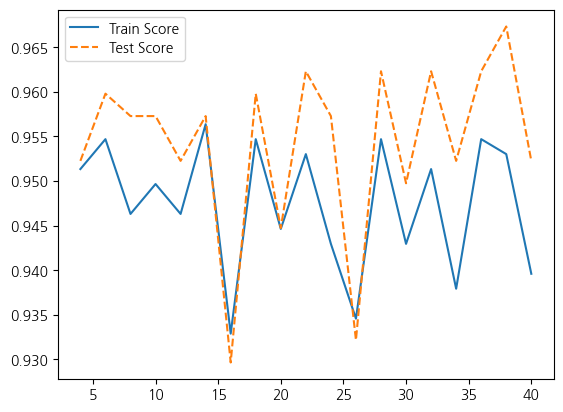

In [71]:
# 모델 설명력 확인 그래프
plt.plot(para_split,train_score,linestyle="-",label="Train Score")
plt.plot(para_split,test_score,linestyle="--",label="Test Score")
plt.legend()

- test 정확도가 높아지는 순간인 min_samples_split = 10으로 선택했다.

### max_depth 값에 따라 비교

In [72]:
# train 및 test 설명력 결과 저장
train_score = [];test_score=[]
para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth:
    rf = RandomForestClassifier(n_estimators=25,min_samples_leaf=7,min_samples_split=10,max_depth=v_max_depth)
    rf.fit(df_train_x,df_train_y)
    train_score.append(rf.score(df_train_x,df_train_y))
    test_score.append(rf.score(df_test_x,df_test_y))
    
df_score_depth = pd.DataFrame()
df_score_depth["Depth"] = para_depth
df_score_depth["TrainScore"] = train_score
df_score_depth["TestScore"] = test_score

df_score_depth.round(3)

,Depth,TrainScore,TestScore
0,1,0.849,0.832
1,2,0.849,0.852
2,3,0.916,0.917
3,4,0.926,0.920
4,5,0.953,0.962
5,6,0.953,0.967
6,7,0.955,0.967
7,8,0.953,0.960
8,9,0.955,0.955
9,10,0.951,0.950


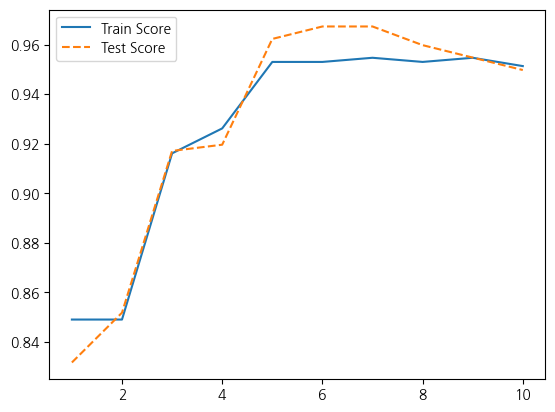

In [73]:
# 모델 설명력 확인 그래프
plt.plot(para_depth,train_score,linestyle="-",label="Train Score")
plt.plot(para_depth,test_score,linestyle="--",label="Test Score")
plt.legend()

- depth가 너무 크면 over-fitting이 되고 4 모델의 성능이 좋아지므로 4로 선택했다.

### 최종 모델 선정

In [74]:
rf_final = RandomForestClassifier(n_estimators=25, min_samples_leaf = 7, min_samples_split = 10, max_depth = 4)
rf_final.fit(df_train_x, df_train_y)

RandomForestClassifier(max_depth=4, min_samples_leaf=7, min_samples_split=10,
                       n_estimators=25)

### 모델 예측 및 성능 평가 

In [75]:
y_pred = rf_final.predict(df_test_x)

print("accuracy on training set: {:.3f}".format(rf_final.score(df_train_x,df_train_y)))
print("accuracy on test set: {:.3f}".format(rf_final.score(df_test_x,df_test_y)))
print("Confusion matrix:\n{}".format(confusion_matrix(df_test_y,y_pred)))

accuracy on training set: 0.930
accuracy on test set: 0.937
Confusion matrix:
[[101  21]
 [  4 272]]


1. 이 모델의 예측 정확도는 0.95이다. **즉, 95% 정도는 정답을 맞춘다.**
2. precision은 270/(276 + 20) = 72/75 = 0.91이다. **즉, 불량이라고 예측한 것 중에 맞춘 비율은 91%이다.**
3. recall은 270/(270 + 0) = 270/270 ≓ 1이다. **즉, 실제로 불량인 것 중에 예측을 맞춘 비율은 약 100%이다.**
4. precision이 더 중요한지 아니면 recall이 더 중요한지는 해당 기업에 어느 부분에 더 가치를 두는지에 따라 달라진다.
- '1 - precision' : 불량이라고 예측했다. 그래서 보수를 했다. 근데 알고보니 불량이 아니다. 이에 대한 비용이 발생했다.
- '1 - recall' : 실제 불량인데 정상적으로 판단해서 보낸 물품. 소비자가 불만을 가지고 추후에 해당 제품을 사용하지 않을 수도 있다.
5. 불량률을 정확하게 찾아내는 것을 중요하게 생각한다면 recall 지수를 중요하게 봐야한다.
- 후판 공정에서 불량을 찾아내기 위해 recall 지수가 1인 현재 모델은 좋은 성능을 보여준다고 할 수 있다.

### 최종 모델에서의 설명변수의 중요도

In [76]:
v_feature_name = df_train_x.columns

df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = rf_final.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance.round(3)

,Feature,Importance
9,rolling_temp,0.223
0,pt_thick,0.117
5,fur_soak_temp,0.113
8,fur_ex_temp,0.086
2,pt_length,0.084
1,pt_width,0.071
19,hsb_미적용,0.053
20,hsb_적용,0.048
14,spec_country_일본,0.042
17,steel_kind_C,0.036


Text(0, 0.5, 'variable')

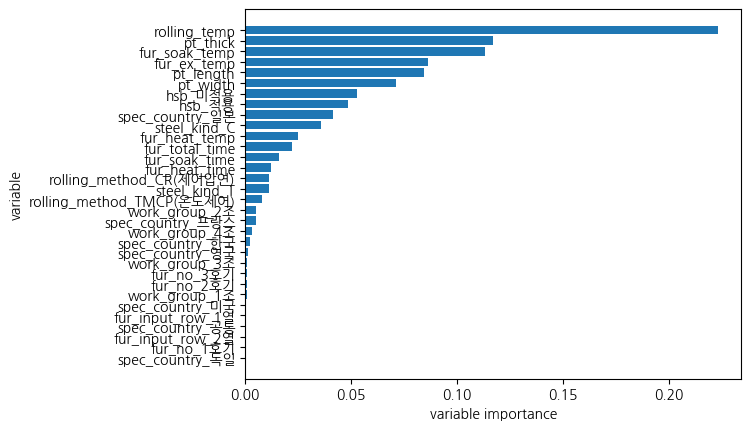

In [77]:
# 중요도가 높은 변수를 상위에 그림
df_importance.sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("variable importance")
plt.ylabel("variable")

압연온도, 후판 지시두께, 후판 지시길이, 가열로 추출온도 순으로 scale 불량에 영향을 많이 미치는 것으로 나타났다.
- **압연온도가 "높을수록" scale 불량일 가능성이 높다.**
- **plate의 너비가 "클수록" scale 불량일 가능성이 높다.**
- **plate의 길이가 "길수록" scale 불량일 가능성이 높다.**
- **추출온도가 "높을수록" scale 불량일 가능성이 높다.**

## Support Vector Machine (Classifier)

### 기본 설정으로 모델 생성

In [78]:
svm_uncustomized = SVC()
svm_uncustomized.fit(df_train_x,df_train_y)

print("Accuracy on training set:{:.3f}".format(svm_uncustomized.score(df_train_x,df_train_y)))
print("Accuracy on test set:{:.3f}".format(svm_uncustomized.score(df_test_x,df_test_y)))

Accuracy on training set:0.913
Accuracy on test set:0.872


- 기본 설정만으로도 성능이 train 에서 0.913, test 에서 0.872 로 꽤 좋은 편이다.

### C(cost) 조정

In [79]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []

para_c = [10**c for c in range(-2, 2)]

for v_C in para_c:
    svm = SVC(C = v_C, random_state = 1234)
    svm.fit(df_train_x, df_train_y)
    train_accuracy.append(svm.score(df_train_x, df_train_y))
    test_accuracy.append(svm.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_c = pd.DataFrame()
df_accuracy_c["C"] = para_c
df_accuracy_c["TrainAccuracy"] = train_accuracy
df_accuracy_c["TestAccuracy"] = test_accuracy
df_accuracy_c.round(3)

,C,TrainAccuracy,TestAccuracy
0,0.01,0.685,0.693
1,0.10,0.829,0.804
2,1.00,0.913,0.872
3,10.00,0.966,0.905


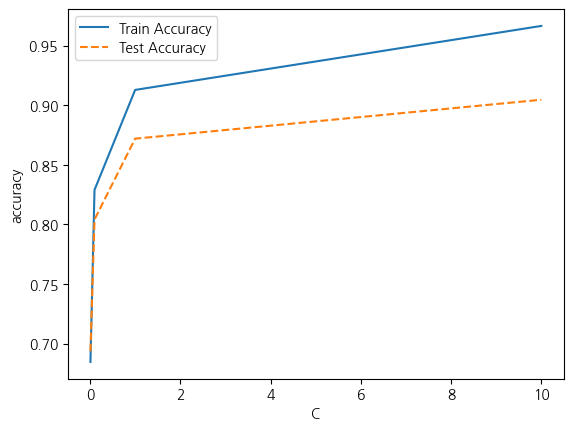

In [80]:
# 정확도를 그래프로 표현
plt.plot(para_c, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_c, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("C")
plt.legend()

- 너무 크면 over-fitting이 되므로 Cost = 1.0으로 선택했다.

### Gamma 조정

In [81]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []

para_gamma = [10**gamma for gamma in range(-2, 2)]

for v_gamma in para_gamma:
    svm = SVC(C=1.0, gamma = v_gamma)
    svm.fit(df_train_x, df_train_y)
    train_accuracy.append(svm.score(df_train_x, df_train_y))
    test_accuracy.append(svm.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_gamma = pd.DataFrame()
df_accuracy_gamma["gamma"] = para_gamma
df_accuracy_gamma["TrainAccuracy"] = train_accuracy
df_accuracy_gamma["TestAccuracy"] = test_accuracy
df_accuracy_gamma.round(3)

,gamma,TrainAccuracy,TestAccuracy
0,0.01,0.861,0.837
1,0.10,0.918,0.874
2,1.00,0.995,0.729
3,10.00,1.000,0.698


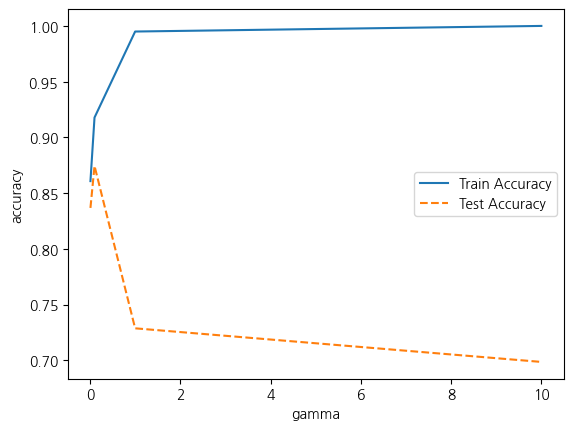

In [82]:
# 정확도를 그래프로 표현
plt.plot(para_gamma, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_gamma, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("gamma")
plt.legend()

- 너무 크면 over-fitting 이고 test 데이터 성능을 고려하여 gamma = 0.10으로 선택했다.

### 최종 SVM 모델 선택

In [83]:
svc_final = SVC(gamma = 0.1, C = 1)
svc_final.fit(df_train_x, df_train_y)

y_pred = svc_final.predict(df_test_x)

print("Accuracy on training set: {:.3f}".format(svc_final.score(df_train_x, df_train_y)))
print("Accuracy on test set: {:.3f}\n".format(svc_final.score(df_test_x, df_test_y)))
print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

Accuracy on training set: 0.918
Accuracy on test set: 0.874

Confusion matrix: 
[[ 86  36]
 [ 14 262]]


1. 이 모델의 예측 정확도는 0.874 이다. **즉, 87% 정도는 정답을 맞춘다.**
2. precision은 262/(262+36) = 0.879 이다. **즉, 불량이라고 예측한 것 중에 맞춘 비율은 약 88%이다.**
3. recall은 262/(262+14) = 0.949 이다. **즉, 실제로 불량인 것 중에 예측을 맞춘 비율은 약 95%이다.**
4. precision이 더 중요한지 아니면 recall이 더 중요한지는 해당 기업에 어느 부분에 더 가치를 두는지에 따라 달라진다.
- '1 - precision' : 불량이라고 예측했다. 그래서 보수를 했다. 근데 알고보니 불량이 아니다. 이에 대한 비용이 발생했다.
- '1 - recall' : 실제 불량인데 정상이라고 판단해서 보낸 물품. 소비자가 불만을 가지고 추후에 해당 제품을 사용하지 않을 수도 있다.
5. 불량률을 정확하게 찾아내는 것을 중요하게 생각한다면 recall 지수를 중요하게 봐야한다.
- 후판 공정에서 불량을 찾아내기 위해 recall 지수가 0.949 인 현재 모델은 좋은 성능을 보여준다고 할 수 있다.

# 모델 평가

In [84]:
# 로지스틱 회귀분석
print("[ Logistic Regression ]")
print("Accuracy:{0:.3f}".format(accuracy_score(df_test["scale"], y_pred_class)))
print("Confusion Matrix: \n{}".format(confusion_matrix(df_test["scale"], y_pred_class)))
print("\n")

# 랜덤포레스트
print("[ Random Forest ]")
print("Accuracy:{0:.3f}".format(rf_final.score(df_test_x, df_test_y)))
print("Confusion Matrix: \n{}".format(confusion_matrix(df_test_y, rf_final.predict(df_test_x))))
print("\n")

# 서포트벡터머신
print("[ Support Vector Machine ]")
print("Accuracy: {:.3f}".format(svc_final.score(df_test_x, df_test_y)))
print("Confusion Matrix: \n{}".format(confusion_matrix(df_test_y, svc_final.predict(df_test_x))))
print("\n")

[ Logistic Regression ]
Accuracy:0.862
Confusion Matrix: 
[[ 90  32]
 [ 23 253]]


[ Random Forest ]
Accuracy:0.937
Confusion Matrix: 
[[101  21]
 [  4 272]]


[ Support Vector Machine ]
Accuracy: 0.874
Confusion Matrix: 
[[ 86  36]
 [ 14 262]]




# 결론

## LogisticRegression 모델평가
1. 이 모델의 예측 정확도는 0.862이다. **즉, 86.2% 정도는 정답을 맞춘다.**
2. precision은 253/(253 + 32) = 253/285 ≓ 0.88 이다. **즉, 불량이라고 예측한 것 중에 맞춘 비율은 약 88%이다.**
3. recall은 253/(23 + 253) = 253/286 ≓ 0.92 이다. **즉, 실제로 불량인 것 중에 예측을 맞춘 비율은 약 92%이다.**
4. precision이 더 중요한지 아니면 recall이 더 중요한지는 해당 기업에 어느 부분에 더 가치를 두는지에 따라 달라진다.
- '1 - precision' : 불량이라고 예측했다. 그래서 보수를 했다. 근데 알고보니 불량이 아니다. 이에 대한 비용이 발생했다.
- '1 - recall' : 실제 불량인데 정상이라고 판단해서 보낸 물품. 소비자가 불만을 가지고 추후에 해당 제품을 사용하지 않을 수도 있다.
- 즉, 불량률에 관심이 많은 recall 지표가 0.92 인 것은 의미가 있다고 할 수 있다.

## RandomForest 모델평가
1. 이 모델의 예측 정확도는 0.95이다. **즉, 95% 정도는 정답을 맞춘다.**
2. precision은 270/(276 + 20) = 72/75 = 0.91이다. **즉, 불량이라고 예측한 것 중에 맞춘 비율은 91%이다.**
3. recall은 270/(270 + 0) = 270/270 ≓ 1이다. **즉, 실제로 불량인 것 중에 예측을 맞춘 비율은 약 100%이다.**
4. precision이 더 중요한지 아니면 recall이 더 중요한지는 해당 기업에 어느 부분에 더 가치를 두는지에 따라 달라진다.
- '1 - precision' : 불량이라고 예측했다. 그래서 보수를 했다. 근데 알고보니 불량이 아니다. 이에 대한 비용이 발생했다.
- '1 - recall' : 실제 불량인데 정상적으로 판단해서 보낸 물품. 소비자가 불만을 가지고 추후에 해당 제품을 사용하지 않을 수도 있다.
5. 불량률을 정확하게 찾아내는 것을 중요하게 생각한다면 recall 지수를 중요하게 봐야한다.
- 후판 공정에서 불량을 찾아내기 위해 recall 지수가 1인 현재 모델은 좋은 성능을 보여준다고 할 수 있다.

## SVM 모델평가
1. 이 모델의 예측 정확도는 0.874 이다. **즉, 87% 정도는 정답을 맞춘다.**
2. precision은 262/(262+36) = 0.879 이다. **즉, 불량이라고 예측한 것 중에 맞춘 비율은 약 88%이다.**
3. recall은 262/(262+14) = 0.949 이다. **즉, 실제로 불량인 것 중에 예측을 맞춘 비율은 약 95%이다.**
4. precision이 더 중요한지 아니면 recall이 더 중요한지는 해당 기업에 어느 부분에 더 가치를 두는지에 따라 달라진다.
- '1 - precision' : 불량이라고 예측했다. 그래서 보수를 했다. 근데 알고보니 불량이 아니다. 이에 대한 비용이 발생했다.
- '1 - recall' : 실제 불량인데 정상이라고 판단해서 보낸 물품. 소비자가 불만을 가지고 추후에 해당 제품을 사용하지 않을 수도 있다.
5. 불량률을 정확하게 찾아내는 것을 중요하게 생각한다면 recall 지수를 중요하게 봐야한다.
- 후판 공정에서 불량을 찾아내기 위해 recall 지수가 0.949 인 현재 모델은 좋은 성능을 보여준다고 할 수 있다.

## 1. accuracy 비교
- **Random Forest**가 정분류율이 0.95으로 가장 높으며 분류를 잘 한다.  
- 즉, 실제 불량과 양품에 대해 일치하는 예측값에 대해 가장 높으며 이는 대표적인 분로 모델의 성능지표이다.

## 2. precision & recall 비교

#### logistic regression
- 불량이라고 예측한 것 중에 맞춘 비율은 약 78%이다.
- 실제로 불량인 것 중에 예측을 맞춘 비율은 약 82%이다.

#### random forest
- 불량이라고 예측한 것 중에 맞춘 비율은 96%이다.
- 실제로 불량인 것 중에 예측을 맞춘 비율은 약 76%이다.

#### svm
- 불량이라고 예측한 것 중에 맞춘 비율은 84%이다.
- 실제로 불량인 것 중에 예측을 맞춘 비율은 약 71%이다.

## 후판 공정 불량률
- 후판 공정에서는 불량률을 정확하게 찾아내는 것을 중요하게 생각하기때문에 recall 지수를 중요하게 봐야한다.
- 후판 공정에서 불량을 찾아내기 위해 recall 지수가 0.949 인 RandomForest 모델이 좋은 성능을 보여준다고 할 수 있다.

## 3. 모델들이 선정한 중요한 변수

### 1) 로지스틱 회귀  
HSB 적용 여부 , 제품 규격 기준국(spec_country) , 압연방법(rolling_method) 순으로 scale 불량에 영향을 많이 미치는 것으로 나타났다.
- **HSB 과정을 "진행하지 않았을 때" scale 불량일 가능성이 높다.**
- **제품 규격기준이 한국, 프랑스, 일본, 영국, 미국, 독일 에서 불량 가능서이 낮다**
- **rolling_method 가 TMCP(온도제어)" 일 때 불량일 가능성이 높다.**
- **압연온도가 "높을수록" scale 불량일 가능성이 높다.**
- **가열로 균열대 온도가 "높을수록" scale 불량일 가능성이 높다.**

### 2) 랜덤 포레스트  
압연온도, 후판 지시두께, 후판 지시길이, 가열로 추출온도 순으로 scale 불량에 영향을 많이 미치는 것으로 나타났다.
- **압연온도가 "높을수록" scale 불량일 가능성이 높다.**
- **plate의 너비가 "클수록" scale 불량일 가능성이 높다.**
- **plate의 길이가 "길수록" scale 불량일 가능성이 높다.**
- **추출온도가 "높을수록" scale 불량일 가능성이 높다.**

## → 두 모델이 공통적으로 생각한 scale 불량에 영향을 크게 미치는 변수 
- 압연온도, 가열로 균열대 온도는 후판 제조 불량률에 큰 영향을 미치며 불량률이 높은 것은 판매액의 저하로 이어진다.
- 즉, 판매액을 높이기위해선 불량률을 최소화하는 것이 우선순위이며 불량률을 찾기위한 가장 좋은 성능을 가진 모델은 RandomForest 이다.